In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,torch,torchvision,cv2,PIL,matplotlib

CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3


In [2]:
import os, sys, io
import numpy as np
import cv2
import random
import PIL.Image as Image
import torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
from IPython.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [3]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

[SimHei Font: qsxp](https://pan.baidu.com/s/1AkoHvYbCYgLSJZDrCVv8RA "提取码: qsxp")

In [4]:
zh_font = FontProperties(fname='/data/font/simhei.ttf')

----------------------------

## Plate Detection Using Yolov5 (车牌提取)

### Dataset

[CCPD2019](https://github.com/detectRecog/CCPD)

[BaiduYun Drive(code: ol3j)](https://pan.baidu.com/s/1JSpc9BZXFlPkXxRK4qUCyw)

In [5]:
data_root = '/data/datasets/cv/CCPD2019'

!ls $data_root $data_root/splits

/data/datasets/cv/CCPD2019:
CCPD2019.tar.gz  ccpd_base	 ccpd_db  ccpd_rotate	images
LICENSE		 ccpd_blur	 ccpd_fn  ccpd_tilt	labels
README.md	 ccpd_challenge  ccpd_np  ccpd_weather	splits

/data/datasets/cv/CCPD2019/splits:
ccpd_blur.txt	    ccpd_db.txt  ccpd_rotate.txt  test.txt   val.txt
ccpd_challenge.txt  ccpd_fn.txt  ccpd_tilt.txt	  train.txt


In [6]:
%%bash

mkdir -p /data/codes

if [[ ! -d /data/codes/yolov5 ]]
then
    git clone https://github.com/ultralytics/yolov5 /data/codes/yolov5
    cd /data/codes/yolov5 && pip3 install -r requirements.txt > /dev/null
fi

### Data Preprocess

In [7]:
def read_data(phase):
    with open(os.path.join(data_root, 'splits', f'{phase}.txt')) as fr:
        # data = fr.readlines()
        data = fr.read().splitlines()
    return data

In [8]:
test_data = read_data('test')
test_data[-6]

'ccpd_tilt/1128-27_21-97&485_423&774-409&774_97&611_111&485_423&648-0_0_32_32_5_31_27-121-271.jpg'

In [9]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", 
             "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]

alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U',
             'V', 'W', 'X', 'Y', 'Z', 'O']

ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
       'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

```
                           97&485_423&774
                      | {left up}_{right bottom}
                      |
   0         1        |   2                   3                         4               5            6
{area}-{tilt degree}-{bounding box}-{four vertices locations}-{license plate number}-{brightness}-{blurriness}
        |                                                       |
        | {horizontal tilt degree}_{vertical_tilt_degree}       |
                                27_21                           | {provinces}_{alphabets}_{ads}
                                                                         0_0_32_32_5_31_27
```

In [10]:
def parse_bbox_and_lpn(filename):
    segs = filename.split('-')
    bbox_vertices = segs[2].split('_')
    bbox_left_up = [int(x) for x in bbox_vertices[0].split('&')]
    bbox_right_bottom = [int(x) for x in bbox_vertices[1].split('&')]
    lps = [int(x) for x in segs[4].split('_')]
    return bbox_left_up, bbox_right_bottom, lps

def lpn_index2name(lpn):
    if len(lpn) != 7:
        raise
    return [provinces[lpn[0]]] + [alphabets[lpn[1]]] + [ads[lpn[i]] for i in range(2, 7)]

In [11]:
x1y1, x2y2, lpn = parse_bbox_and_lpn(test_data[-6])
x1y1, x2y2, lpn

([97, 485], [423, 774], [0, 0, 32, 32, 5, 31, 27])

In [12]:
x1y1, x2y2, lpn_index2name(lpn)

([97, 485], [423, 774], ['皖', 'A', '8', '8', 'F', '7', '3'])

#### Visualize Single Sample 

In [13]:
sample_image_file = os.path.join(data_root, test_data[-6])
sample_image_rgb = cv2.cvtColor(cv2.imread(sample_image_file), cv2.COLOR_BGR2RGB)
image_height, image_width = sample_image_rgb.shape[0:2]
image_height, image_width, sample_image_rgb.shape

(1160, 720, (1160, 720, 3))

In [14]:
sample_image_box = cv2.rectangle(sample_image_rgb, tuple(x1y1), tuple(x2y2), (0, 255, 0), 2)

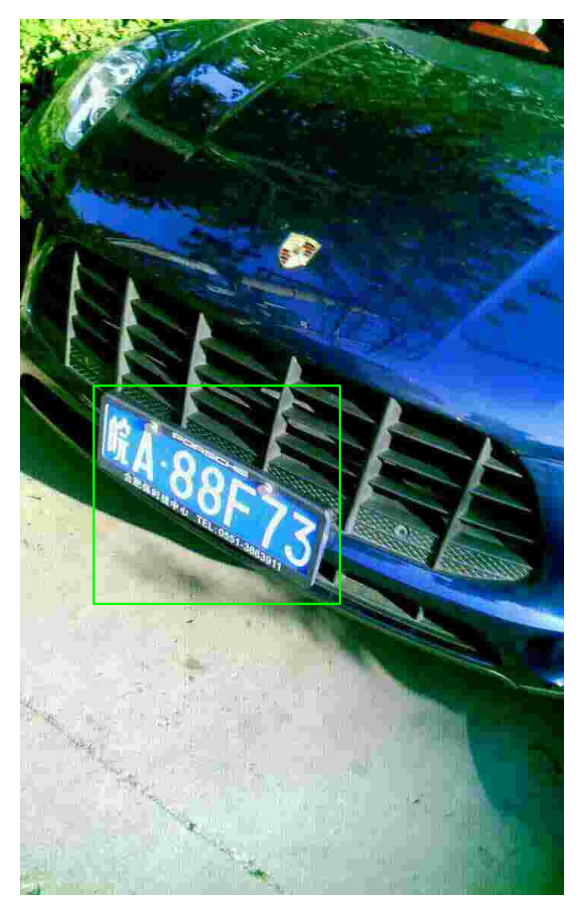

In [15]:
dpi = 100
fig_w, fig_h = 0.5*image_width/dpi, 0.5*image_height/dpi
plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
plt.imshow(sample_image_box)
plt.axis('off');

#### Visualize Subplots Sample 

[SimHei Font: qsxp](https://pan.baidu.com/s/1AkoHvYbCYgLSJZDrCVv8RA "提取码: qsxp")

In [16]:
zh_font = FontProperties(fname='/data/font/simhei.ttf', size=14)

def visualize_data_subplots(rows, cols, images, titles=None, gray=False, isbgr=False, resize=None, dpi=100, return_image=False):
    if isinstance(images[0], str):
        max_h, max_w = 0.8*rows*dpi, 0.8*cols*dpi
    else:
        max_h = max([ x.shape[0] for x in images])
        max_w = max([ x.shape[1] for x in images])
    figsize = (5 * int(max_w / dpi + 1), 5 * int(max_h / dpi + 1))
    fig = plt.figure(figsize=figsize, dpi=dpi)
    if titles is None:
        titles = [str(i) for i in range(1, len(images) + 1)]
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(titles[i], fontproperties=zh_font)
        # plt.xticks([])
        # plt.yticks([])
        plt.axis(False)
        img = images[i]
        if isinstance(img, str):
            img = cv2.imread(img)
            isbgr = True
        if resize:
            if isinstance(resize, int):
                resize = (resize, resize)
            img = cv2.resize(img, resize)
        if isbgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if gray:
            plt.imshow(img, cmap=plt.cm.gray)
        else: 
            plt.imshow(img)
    plt.tight_layout()
    if return_image:
        with io.BytesIO() as fw:
            plt.savefig(fw)
            fw.seek(0)
            return np.array(Image.open(fw)) 
    
def imshow(img, figsize=(8, 8), gray=False, isbgr=False):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if isbgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    if gray:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img)

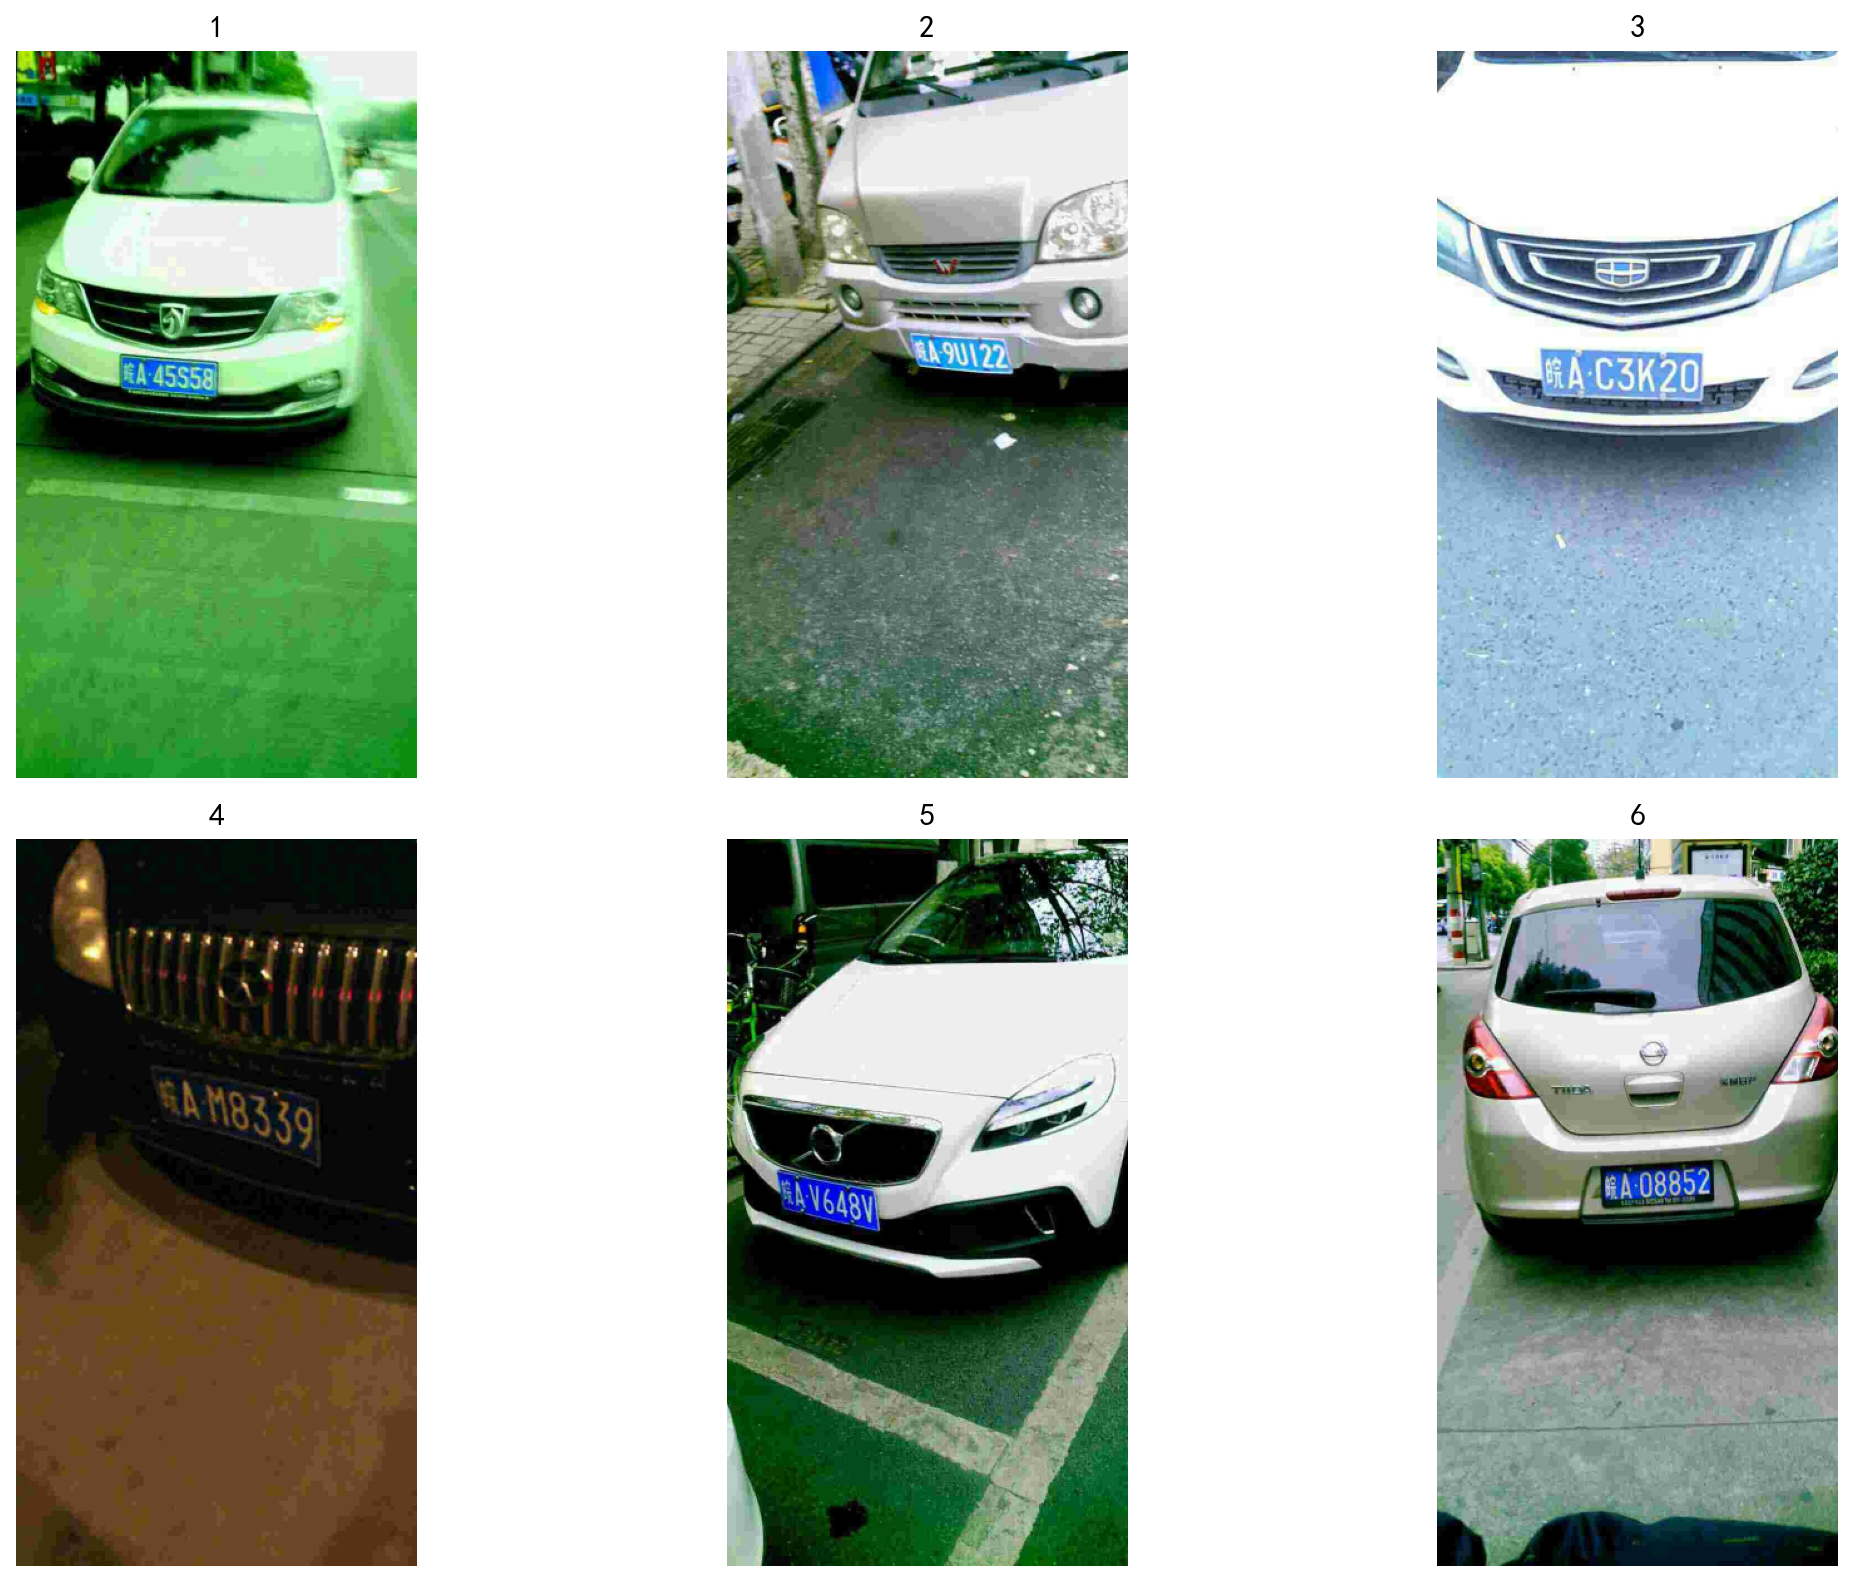

In [17]:
rows, cols = 2, 3
train_data = read_data('train')
images_sample_list = [os.path.join(data_root, train_data[i]) for i in range(cols*rows)]

visualize_data_subplots(rows, cols, images_sample_list, resize=(320, 580), dpi=80)

#### Data Convert to Yolov5 

In [18]:
def yolo_data_generate(phase, num=-1, force=False):
    # prepare data path
    phase_images_path = os.path.join(data_root, 'images', phase)
    phase_labels_path = os.path.join(data_root, 'labels', phase)
    if os.path.exists(phase_images_path) and \
        os.path.exists(phase_labels_path) and \
            not force:
                print(f'{phase} already exist')
                return
    os.makedirs(phase_images_path, exist_ok=True)
    os.makedirs(phase_labels_path, exist_ok=True)
    
    # parse file and format convert
    files_list = read_data(phase)
    if num > 0:
        files_list = files_list[:num]
    for filepath in files_list:
        basename = os.path.basename(filepath)
        image_src_path = os.path.join(data_root, filepath)
        image_dst_path = os.path.join(phase_images_path, basename)
        label_dst_path = os.path.join(phase_labels_path, basename.split('.')[0] + '.txt')
        x1y1, x2y2, _ = parse_bbox_and_lpn(basename)
        image_bgr = cv2.imread(image_src_path)
        bbox = yolo_normal_convert(image_bgr.shape[1], image_bgr.shape[0], *x1y1, *x2y2)
        ## generate label file
        with open(label_dst_path, 'w') as fw:
            fw.write('0 %.6f %.6f %.6f %.6f' % bbox)
        ## copy image file
        shutil.copy(image_src_path, image_dst_path)

In [19]:
yolo_data_generate('train', force=False)
yolo_data_generate('val', num=1000, force=False)
# yolo_data_generate('test', force=False)

train already exist
val already exist


In [20]:
def yolo_normal_convert(width, height, x1, y1, x2, y2):
    dw, dh = 1.0 / width, 1.0 / height
    bw, bh = (x2 - x1), (y2 - y1)
    cx, cy = (x1 + x2) / 2.0 - 1, (y1 + y2) / 2.0 - 1
    return round(cx * dw, 6), round(cy * dh, 6), round(bw * dw, 6), round(bh * dh, 6)
yolo_normal_convert(200, 200, 0, 0, 200, 200)

(0.495, 0.495, 1.0, 1.0)

### Yolov5 Train 

#### GPU Info

In [21]:
!nvidia-smi

Mon Apr 12 19:56:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:00:06.0 Off |                    0 |
| N/A   31C    P0    49W / 250W |   2156MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Download Yolov5 Codes

In [22]:
%%bash

mkdir -p /data/codes

export YOLOV5_ROOT=/data/codes/yolov5

if [[ ! -d $YOLOV5_ROOT ]]
then
    git clone https://github.com/ultralytics/yolov5 $YOLOV5_ROOT
    cd $YOLOV5_ROOT && pip3 install -r requirements.txt > /dev/null
fi

#### Setup Configure Files

- `${YOLOV5_ROOT}/data/CCPD2019/dataset.yaml`

> ```yaml
> train: /data/datasets/cv/CCPD2019/images/train   
> val: /data/datasets/cv/CCPD2019/images/val   
> 
> nc: 1
> 
> names: ['licenseplates']
> ```


- `${YOLOV5_ROOT}/data/CCPD2019/hyperparameters.yaml`

>```yaml
> lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)  
> lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)   
> momentum: 0.937  # SGD momentum/Adam beta1  
> weight_decay: 0.0005  # optimizer weight decay 5e-4  
> warmup_epochs: 3.0  # warmup epochs (fractions ok)   
> warmup_momentum: 0.8  # warmup initial momentum
> warmup_bias_lr: 0.1  # warmup initial bias lr
> box: 0.05  # box loss gain
> cls: 0.5  # cls loss gain
> cls_pw: 1.0  # cls BCELoss positive_weight
> obj: 1.0  # obj loss gain (scale with pixels)
> obj_pw: 1.0  # obj BCELoss positive_weight
> iou_t: 0.20  # IoU training threshold
> anchor_t: 4.0  # anchor-multiple threshold
> # anchors: 3  # anchors per output layer (0 to ignore)
> fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
> hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
> hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
> hsv_v: 0.4  # image HSV-Value augmentation (fraction)
> degrees: 0.0  # image rotation (+/- deg)
> translate: 0.1  # image translation (+/- fraction)
> scale: 0.5  # image scale (+/- gain)
> shear: 0.0  # image shear (+/- deg)
> perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
> flipud: 0.0  # image flip up-down (probability)
> fliplr: 0.5  # image flip left-right (probability)
> mosaic: 1.0  # image mosaic (probability)
> mixup: 0.0  # image mixup (probability)
> ```


- `${YOLOV5_ROOT}/data/CCPD2019/yolov5s.yaml`

> ```yaml
> # parameters
> nc: 1  # number of classes
> depth_multiple: 0.33  # model depth multiple
> width_multiple: 0.50  # layer channel multiple
> 
> # anchors
> anchors:
>   - [10,13, 16,30, 33,23]  # P3/8
>   - [30,61, 62,45, 59,119]  # P4/16
>   - [116,90, 156,198, 373,326]  # P5/32
> 
> # YOLOv5 backbone
> backbone:
>   # [from, number, module, args]
>   [[-1, 1, Focus, [64, 3]],  # 0-P1/2
>    [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
>    [-1, 3, BottleneckCSP, [128]],
>    [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
>    [-1, 9, BottleneckCSP, [256]],
>    [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
>    [-1, 9, BottleneckCSP, [512]],
>    [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
>    [-1, 1, SPP, [1024, [5, 9, 13]]],
>    [-1, 3, BottleneckCSP, [1024, False]],  # 9
>   ]
> 
> # YOLOv5 head
> head:
>   [[-1, 1, Conv, [512, 1, 1]],
>    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
>    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
>    [-1, 3, BottleneckCSP, [512, False]],  # 13
> 
>    [-1, 1, Conv, [256, 1, 1]],
>    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
>    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
>    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)
> 
>    [-1, 1, Conv, [256, 3, 2]],
>    [[-1, 14], 1, Concat, [1]],  # cat head P4
>    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)
> 
>    [-1, 1, Conv, [512, 3, 2]],
>    [[-1, 10], 1, Concat, [1]],  # cat head P5
>    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)
> 
>    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
>   ]
> ```

#### Execute Bash Script (DDP)

edit `$YOLOV5_ROOT/data/CCPD2019/train.sh`

```bash

#!/bin/bash

prog_name=$(basename $0)
master_addr=10.255.0.58
master_port=8555
nodes_num=1
procs_num=1
node_index=0
batch_size=96
ddp=False
level=s
out_dir=/data/result/CCPD2019

__usage() {
    echo ""
    echo "${prog_name} arguments:"
    echo "-m or --master master_addr:master_port"
    echo "-n or --nodes node/nnodes like 1/3"
    echo "-p or --procs num"
    echo "-l or --level"
    echo "-b or --bs batchsize"
    echo "-o or --output"
    echo "-h or --help"
    echo ""
}

ARGUMENT_LIST=(
    "master"
    "nodes"
    "procs"
    "level"
    "out"
    "bs"
)

opts=$(getopt \
    --options "$(printf "%.1s:" "${ARGUMENT_LIST[@]}")h::" \
    --longoptions "$(printf "%s:," "${ARGUMENT_LIST[@]}")help::" \
    --name "$prog_name" \
    -- "$@"
)

eval set --$opts

while [[ $# -gt 0 ]]; do
    case "$1" in
        -o|--out)
            out_dir=$2
            shift 2
            ;;

        -m|--master)
            ddp=True
            master_addr=`echo $2 | cut -d: -f1`
            master_port=`echo $2 | cut -d: -f2`
            shift 2
            ;;

        -n|--nodes)
            ddp=True
            nodes_num=`echo $2 | cut -d/ -f2`
            node=`echo $2 | cut -d/ -f1`
            node_index=`expr $node - 1`
            shift 2
            ;;

        -p|--procs)
            ddp=True
            procs_num=$2
            shift 2
            ;;

        -l|--level)
            ddp=True
            level=$2
            shift 2
            ;;

        -b|--bs)
            batch_size=$2
            shift 2
            ;;

        -h|--help)
            __usage && exit 1
            ;;

        *)
            break
            ;;
    esac
done

batch_size=`expr $batch_size \* $nodes_num`
data_root=data/CCPD2019

commargs="--img-size 640 --batch-size $batch_size --epochs 30 --device 0 \
    --workers 4 --project $out_dir --name $level --exist-ok \
    --data $data_root/dataset.yaml \
    --cfg $data_root/yolov5$level.yaml \
    --hyp $data_root/hyperparameters.yaml \
    --weights 'weights/yolov5$level.pt'"

__kill_resource() {
    pid=`ps -eo pid,args | grep "train.py" | grep -v "grep" | cut -c 1-6`
    if [[ x$pid != x ]]
    then
        echo "kill $pid"
        kill -9 $pid
    fi
}

__kill_resource

if [[ x$ddp == xTrue ]]
then
    echo "DDP run $batch_size"
    python3 -m torch.distributed.launch \
        --nproc_per_node=$procs_num --nnodes=$nodes_num --node=$node_index \
        --master_addr $master_addr --master_port $master_port \
        train.py $commargs
else
    python3 train.py $commargs
fi

__kill_resource

```

#### Start Train

Run `train.sh` in the `$YOLOV5_ROOT`.

A. Single Machine

```bash
./data/CCPD2019/train.sh --bs 64 --out /data/result/CCPD2019
```

B. Multiple GPUs (DDP), eg: I have 3 gpu machines

> node-1 (master)
> ```bash
> ./data/CCPD2019/train.sh --level s --bs 64 --out /data/result/CCPD2019 --nodes 1/3
> ```

> node-2
> ```bash
> ./data/CCPD2019/train.sh --level s --bs 64 --out /data/result/CCPD2019 --nodes 2/3
> ```


> node-3
> ```bash
> ./data/CCPD2019/train.sh --level s --bs 64 --out /data/result/CCPD2019 --nodes 3/3
> ```

#### Train Result

`tree /data/result/CCPD2019 `

> ```
> /data/result/CCPD2019/weights/
> ├── best.pt
> └── last.pt
> ```

### Yolov5 Detect

In [23]:
# add syspath
WEIGHTS_PATH = '/data/result/CCPD2019/weights/last.pt'
IMAGE_SIZE = 512

YOLOV5_ROOT = '/data/codes/yolov5'
PYYOLO_PATH = os.path.dirname(YOLOV5_ROOT)
import sys
if PYYOLO_PATH not in sys.path: 
    sys.path.append(PYYOLO_PATH)
    sys.path.append(YOLOV5_ROOT)
    
# import yolov5
from yolov5.models.experimental import attempt_load
from yolov5.utils.torch_utils import select_device
from yolov5.utils.datasets import LoadImages
from yolov5.utils.general import check_img_size, non_max_suppression
from yolov5.utils.general import scale_coords
from yolov5.utils.plots import plot_one_box

# detect
device = select_device(device='0')
model = attempt_load(WEIGHTS_PATH, map_location=device)
imgsz = check_img_size(IMAGE_SIZE, s=model.stride.max())
model = model.half() # amp
print(imgsz)

conf_thres = 0.35
iou_thres = 0.45

images_predbox_list = []
for img_path in images_sample_list:
    dataset = LoadImages(img_path, img_size=imgsz)
    path, img, im0, _ = next(iter(dataset))
    img = torch.from_numpy(img).to(device)
    img = img.half() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres)
    for i, det in enumerate(pred):
        if len(det) == 0:
            print(f'{path} is not detect pl')
            continue
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
        for *xyxy, conf, cls in reversed(det):
            images_predbox_list.append({
                'image_path': img_path,
                'pred_box': [int(x) for x in xyxy]
            })
            break # we only using first best for test
            
# print result
for jitem in images_predbox_list:
    imgpath = jitem['image_path']
    predbox = jitem['pred_box']
    print(os.path.basename(imgpath).split('-')[2], predbox)

Fusing layers... 
512
181&490_358&548 [186, 483, 364, 551]
329&442_511&520 [330, 448, 513, 517]
173&473_468&557 [183, 471, 480, 560]
255&369_564&505 [244, 365, 546, 502]
90&538_280&616 [87, 526, 276, 630]
301&521_492&580 [299, 519, 495, 580]


In [24]:
images_cropped_list = []
for jitem in images_predbox_list:
    imgpath = jitem['image_path']
    x1, y1, x2, y2 = jitem['pred_box']
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images_cropped_list.append(img[y1:y2, x1:x2, :])

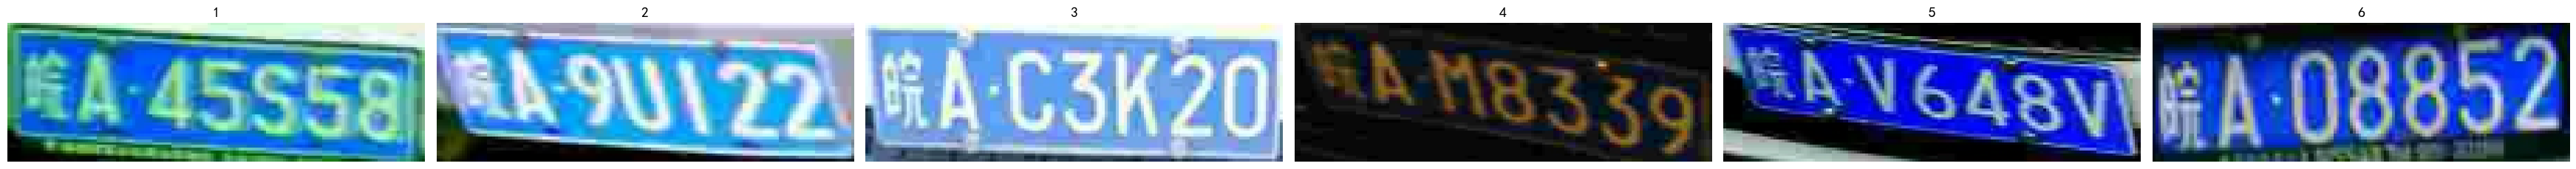

In [25]:
ncols = 6
nrows = int((len(images_sample_list) - 1) / ncols + 1)
visualize_data_subplots(nrows, ncols, images_cropped_list, resize=(150, 50), dpi=50)

### Test Summary

In [26]:
def LPDetect(model, img_path, conf_thres=0.35, iou_thres=0.45):
    device = next(model.parameters()).device
    imgsz = check_img_size(640, s=model.stride.max())
    dataset = LoadImages(img_path, img_size=imgsz)
    path, img, im0, _ = next(iter(dataset))
    img = torch.from_numpy(img).to(device)
    img = img.half() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres)
    if len(pred) > 0:
        det = pred[0]
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
        *xyxy, _conf, _cls = reversed(det)[0] # only best
        x1, y1, x2, y2 = [int(x.cpu()) for x in xyxy]
        # return im0[y1:y2, x1:x2, ::-1] # BGR to RGB
        return im0[y1:y2, x1:x2]
    return None

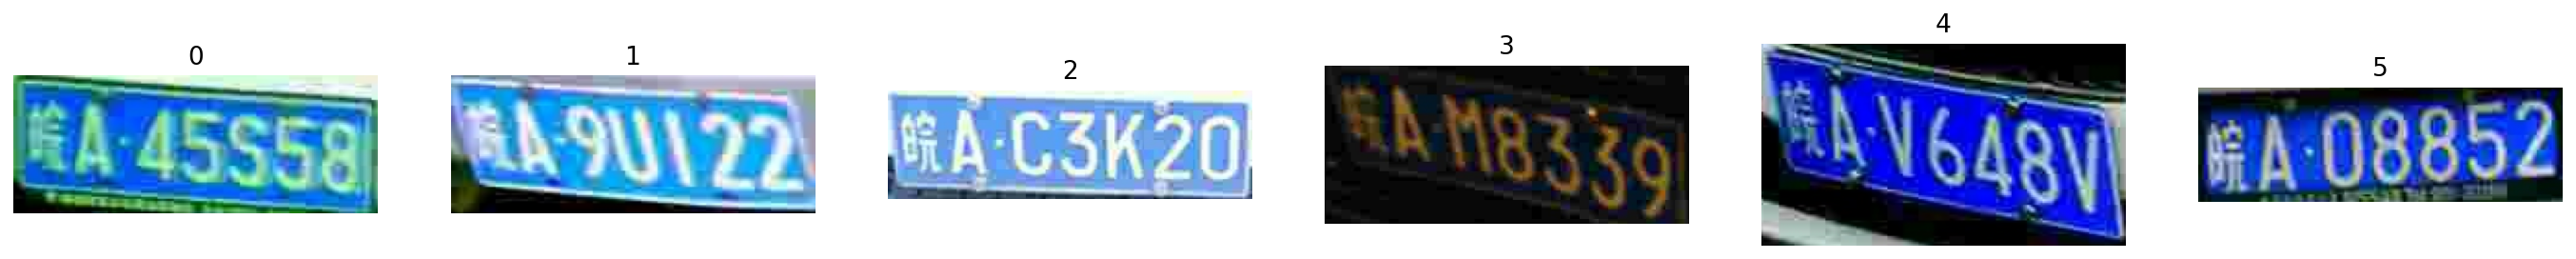

In [27]:
# Test
fig = plt.figure(figsize=(4*ncols, 2*nrows))

grid = gridspec.GridSpec(figure=fig, ncols=ncols, nrows=nrows, hspace=0.2, wspace=0.2)

lp_test_imgs = []
for i, path in enumerate(images_sample_list):
    imgbgr = LPDetect(model, path, 0.45, 0.5)
    if imgbgr is not None:
        fig.add_subplot(grid[i])
        plt.title(f'{i}')
        plt.axis(False)
        plt.imshow(imgbgr[:, :, ::-1])
        lp_test_imgs.append(imgbgr)

--------------

## Character Segmentation (字符提取)

ANPR: Automatic License/Number Plate Recognition

In [28]:
RGB_COLORS = (
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (0, 255, 255),
    (255, 0, 255),
    (192, 192, 192),
    (128, 128, 128),
    (128, 0, 0),
    (128, 128, 0),
    (0, 128, 0),
    (128, 0, 128),
    (0, 128, 128),
    (0, 0, 128)
)

def get_color(i, bgr=False):
    if bgr:
        return RGB_COLORS[i % len(RGB_COLORS)][::-1]
    return RGB_COLORS[i % len(RGB_COLORS)]

### Image Processing 

#### LP Color Mask

TODO

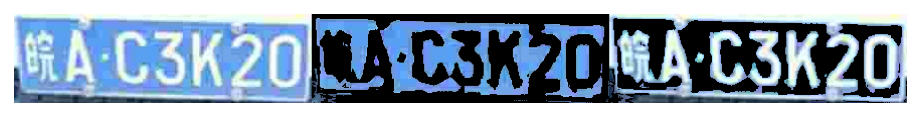

In [29]:
colors = [
    ([26, 43, 46], [34, 255, 255]), # yellow
    # ([100, 43, 46], [124, 255, 255]), # blue
    ([100, 103, 106], [120, 255, 255]), # blue
    ([35, 43, 46], [77, 255, 255]), # green
]

blue_lower = np.array(colors[1][0], np.uint8) # light blue
blue_upper = np.array(colors[1][1], np.uint8) # dark blue

img_bgr = lp_test_imgs[2].copy()
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv, blue_lower, blue_upper)
image_bbox_mask_bgr = cv2.bitwise_and(img_bgr, img_bgr, mask = mask)

mask_inv = cv2.bitwise_not(mask)
image_bbox_mask_inv_bgr = cv2.bitwise_and(img_bgr, img_bgr, mask = mask_inv)

imshow(cv2.hconcat([img_bgr, image_bbox_mask_bgr, image_bbox_mask_inv_bgr]), isbgr=True)

#### Changing Gray Colorspace (reduce value)

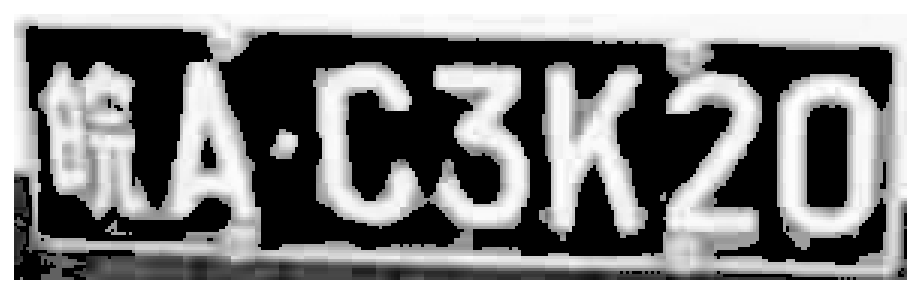

In [30]:
image_bbox_cropped = image_bbox_mask_inv_bgr.copy()
image_bbox_gray = cv2.cvtColor(image_bbox_cropped, cv2.COLOR_BGR2GRAY)
imshow(image_bbox_gray, gray=True)

#### Top and Bottom Edge Cutting

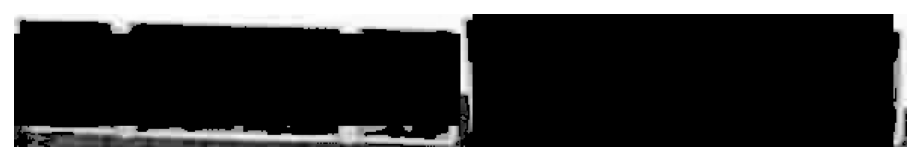

In [31]:
cut_gray_tb_mask = np.zeros(image_bbox_gray.shape[:2], dtype=np.uint8)
cut_gray_tb_mask[0:int(0.15*cut_gray_tb_mask.shape[0]), ::] = 255
cut_gray_tb_mask[int(0.85*cut_gray_tb_mask.shape[0]):, ::] = 255

cut_gray_lr_mask = np.zeros(image_bbox_gray.shape[:2], dtype=np.uint8)
cut_gray_lr_mask[::, 0:int(0.03*cut_gray_lr_mask.shape[1])] = 255
cut_gray_lr_mask[::, int(0.97*cut_gray_lr_mask.shape[1]):] = 255

cut_gray_tb_mask = cv2.bitwise_and(image_bbox_gray, image_bbox_gray, mask=cut_gray_tb_mask)
cut_gray_lr_mask = cv2.bitwise_and(image_bbox_gray, image_bbox_gray, mask=cut_gray_lr_mask)
imshow(cv2.hconcat([cut_gray_tb_mask, cut_gray_lr_mask]), gray=True)

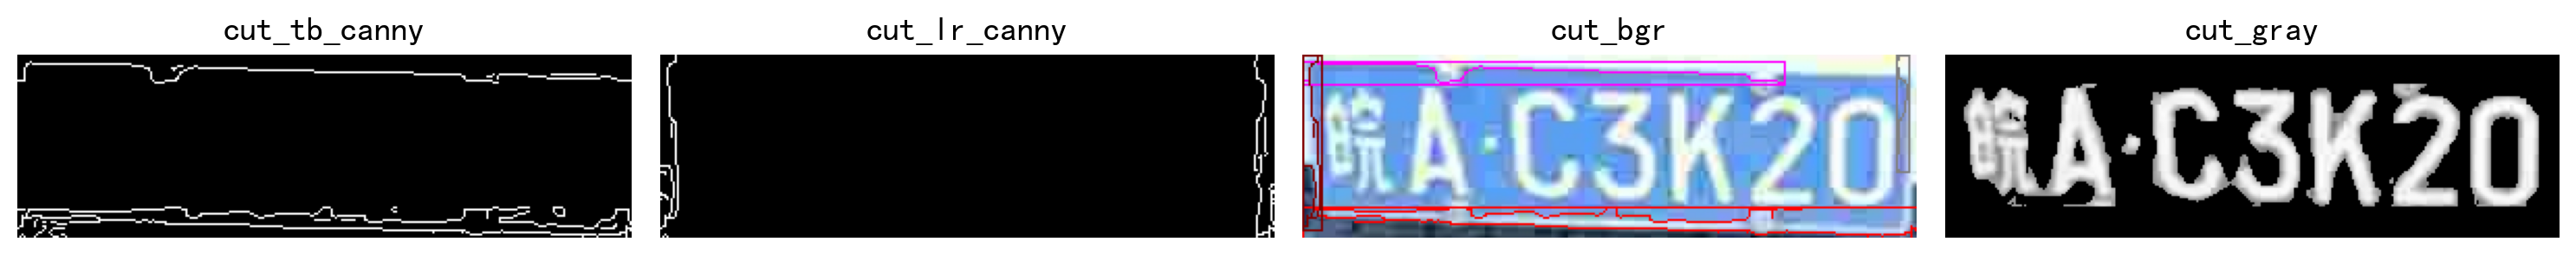

In [32]:
cut_gray_image = image_bbox_gray.copy() 
temp_bgr = img_bgr.copy()

cut_canny_tb_image = cv2.convertScaleAbs(cv2.Canny(cut_gray_tb_mask, 127, 255))
cut_canny_lr_image = cv2.convertScaleAbs(cv2.Canny(cut_gray_lr_mask, 127, 255))

conts = cv2.findContours(cut_canny_tb_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
for i, c in enumerate(conts):
    x, y, w, h = cv2.boundingRect(c)
    # min_rect = cv2.boxPoints(cv2.minAreaRect(c))
    # min_rect = np.uint64(min_rect)
    # cv2.drawContours(temp_bgr, [min_rect], 0, get_color(i, bgr=True), 1)
    # print(x, y, w, h)
    if w > 0.3 * temp_bgr.shape[1]:
        cv2.rectangle(temp_bgr, (x, y), (x+w, y+h), get_color(i, bgr=True), 1)
        cv2.drawContours(temp_bgr, conts, i, get_color(i, bgr=True), 1)
        if y < 0.15 * temp_bgr.shape[0]:
            cut_gray_image[:y+h, ::] = 0
        else:
            cut_gray_image[y:, ::] = 0
            
conts = cv2.findContours(cut_canny_lr_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
for i, c in enumerate(conts):
    x, y, w, h = cv2.boundingRect(c)
    if h > 0.5 * temp_bgr.shape[0]:
        cv2.rectangle(temp_bgr, (x, y), (x+w, y+h), get_color(i, bgr=True), 1)
        cv2.drawContours(temp_bgr, conts, i, get_color(i, bgr=True), 1)
        if x < 0.03 * temp_bgr.shape[1]:
            cut_gray_image[::, :x+w] = 0
        else:
            cut_gray_image[::, x:] = 0
            
visualize_data_subplots(1, 4, [cut_canny_tb_image, cut_canny_lr_image, temp_bgr, cut_gray_image],
                       ['cut_tb_canny', 'cut_lr_canny', 'cut_bgr', 'cut_gray'], isbgr=True)

#### Image Contrast Enhancement

- Histogram Equalization (Global/GHE)

- Adaptive Histogram Equalization (Local/LHE)

- Contrastive Limited Adaptive Equalization (CLAHE)

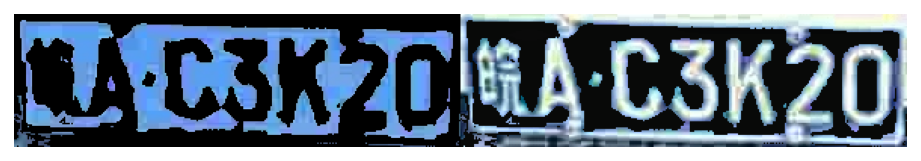

In [33]:
def contrast_using_clahe(image, clip=3.0, tile=(8, 8), gray=False):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    if gray:
        outimg = clahe.apply(image)
    else:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        planes = cv2.split(lab)
        planes[0] = clahe.apply(planes[0])
        # zhchar_pos = int(0.33 * planes[0].shape[1])
        # planes[0][:, zhchar_pos:] = clahe.apply(planes[0][:, zhchar_pos:])
        lab = cv2.merge(planes)
        outimg = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return outimg

image_bbox_clahe_bgr = contrast_using_clahe(image_bbox_mask_inv_bgr, clip=5, tile=(10, 10))
image_bbox_melded_bgr = cv2.hconcat([image_bbox_mask_bgr, image_bbox_clahe_bgr])
imshow(image_bbox_melded_bgr, isbgr=True)

In [34]:
def visualize_cdf_hist(nrow, ncol, images, titles):
    fig = plt.figure(figsize=(5.8*ncols, 3*nrows))
    grid = gridspec.GridSpec(figure=fig, ncols=ncols, nrows=nrows, hspace=0.2, wspace=0.2)
    for i, (image, title) in enumerate(zip(images, titles)):
        hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
        cdf = hist.cumsum()
        # cdf.max() = hight x widht = len(image_bbox_gray.flatten())
        cdf_normalized = cdf * float(hist.max()) / cdf.max()
        fig.add_subplot(grid[i])
        plt.title(title)
        plt.xlim([0, 256])
        plt.plot(cdf_normalized, color='b')
        plt.bar(range(len(hist)), hist, width=1, color='g')
        plt.legend(('cdf', 'histogram'), loc='upper left')

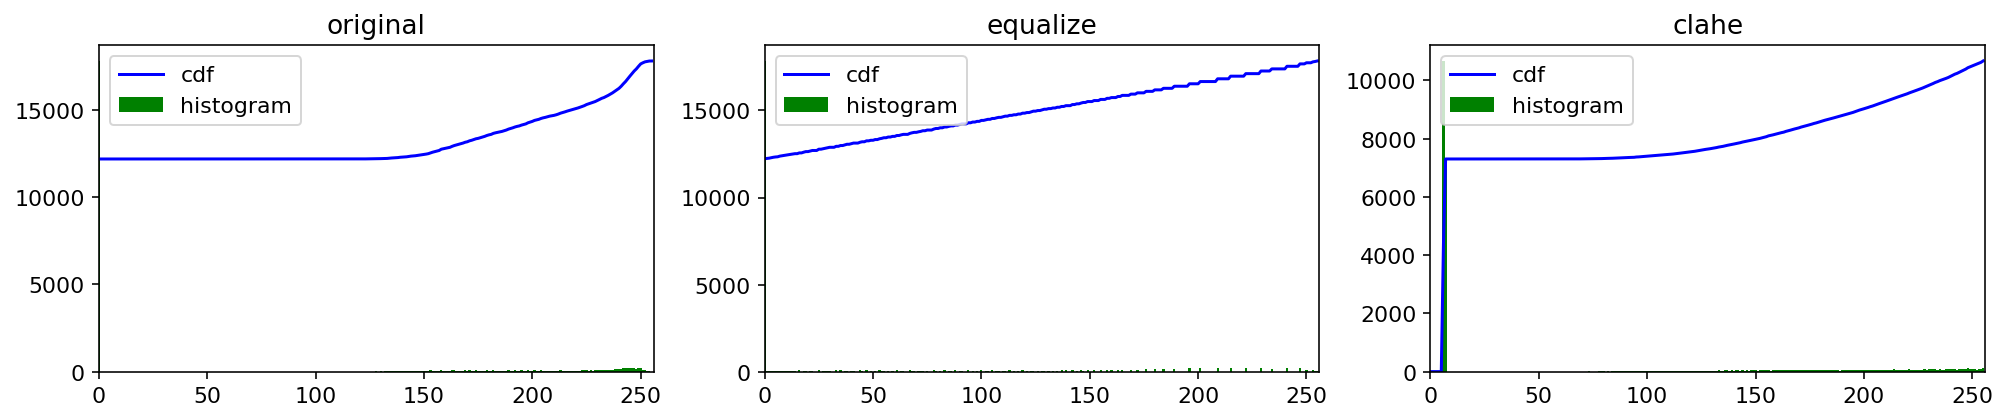

In [35]:
image_bbox = cut_gray_image # image_bbox_gray
image_bbox_ces = {
    'original': image_bbox,
    'equalize': cv2.equalizeHist(image_bbox),
    'clahe': contrast_using_clahe(image_bbox, clip=5, tile=(10, 10), gray=True)
}

visualize_data_subplots(1, len(image_bbox_ces),
                        list(image_bbox_ces.values()),
                        list(image_bbox_ces.keys()),
                        gray=True)

visualize_cdf_hist(1, len(image_bbox_ces),
                        list(image_bbox_ces.values()),
                        list(image_bbox_ces.keys()))

#### Image Smoothing (reduce noise)

- Averaging
$$
K = \frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}
$$

- Gaussian Blurring

> highly effective in removing Gaussian noise

- Median Blurring

>  highly effective against salt-and-pepper noise

- Bilateral Filtering

> highly effective in noise removal while keeping edges sharp

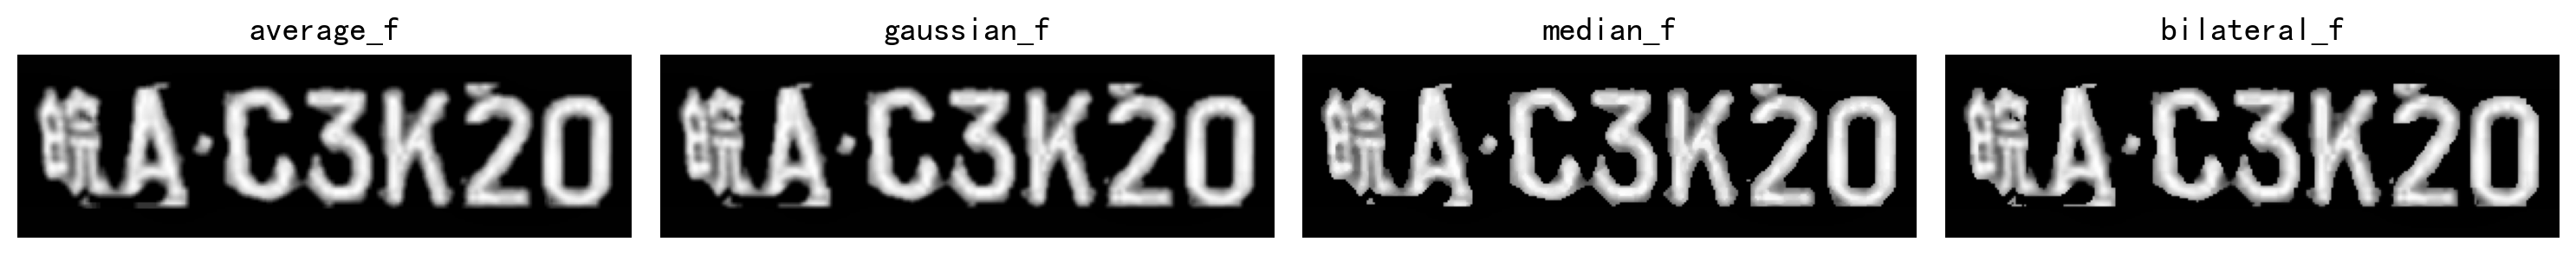

In [36]:
image_bbox = image_bbox_ces['clahe']
ksize = 3

image_bbox_blurs = {
    'average_f': cv2.blur(image_bbox, (ksize, ksize)),
    'gaussian_f': cv2.GaussianBlur(image_bbox, (ksize, ksize), 0),
    'median_f': cv2.medianBlur(image_bbox, ksize),
    'bilateral_f': cv2.bilateralFilter(image_bbox, ksize, 75, 75)
}

visualize_data_subplots(1, len(image_bbox_blurs),
                        list(image_bbox_blurs.values()),
                        list(image_bbox_blurs.keys()),
                        gray=True)

#### Image Thresholding

- Simple Thresholding (Global)

- Adaptive Thresholding

- Otsu's Binarization


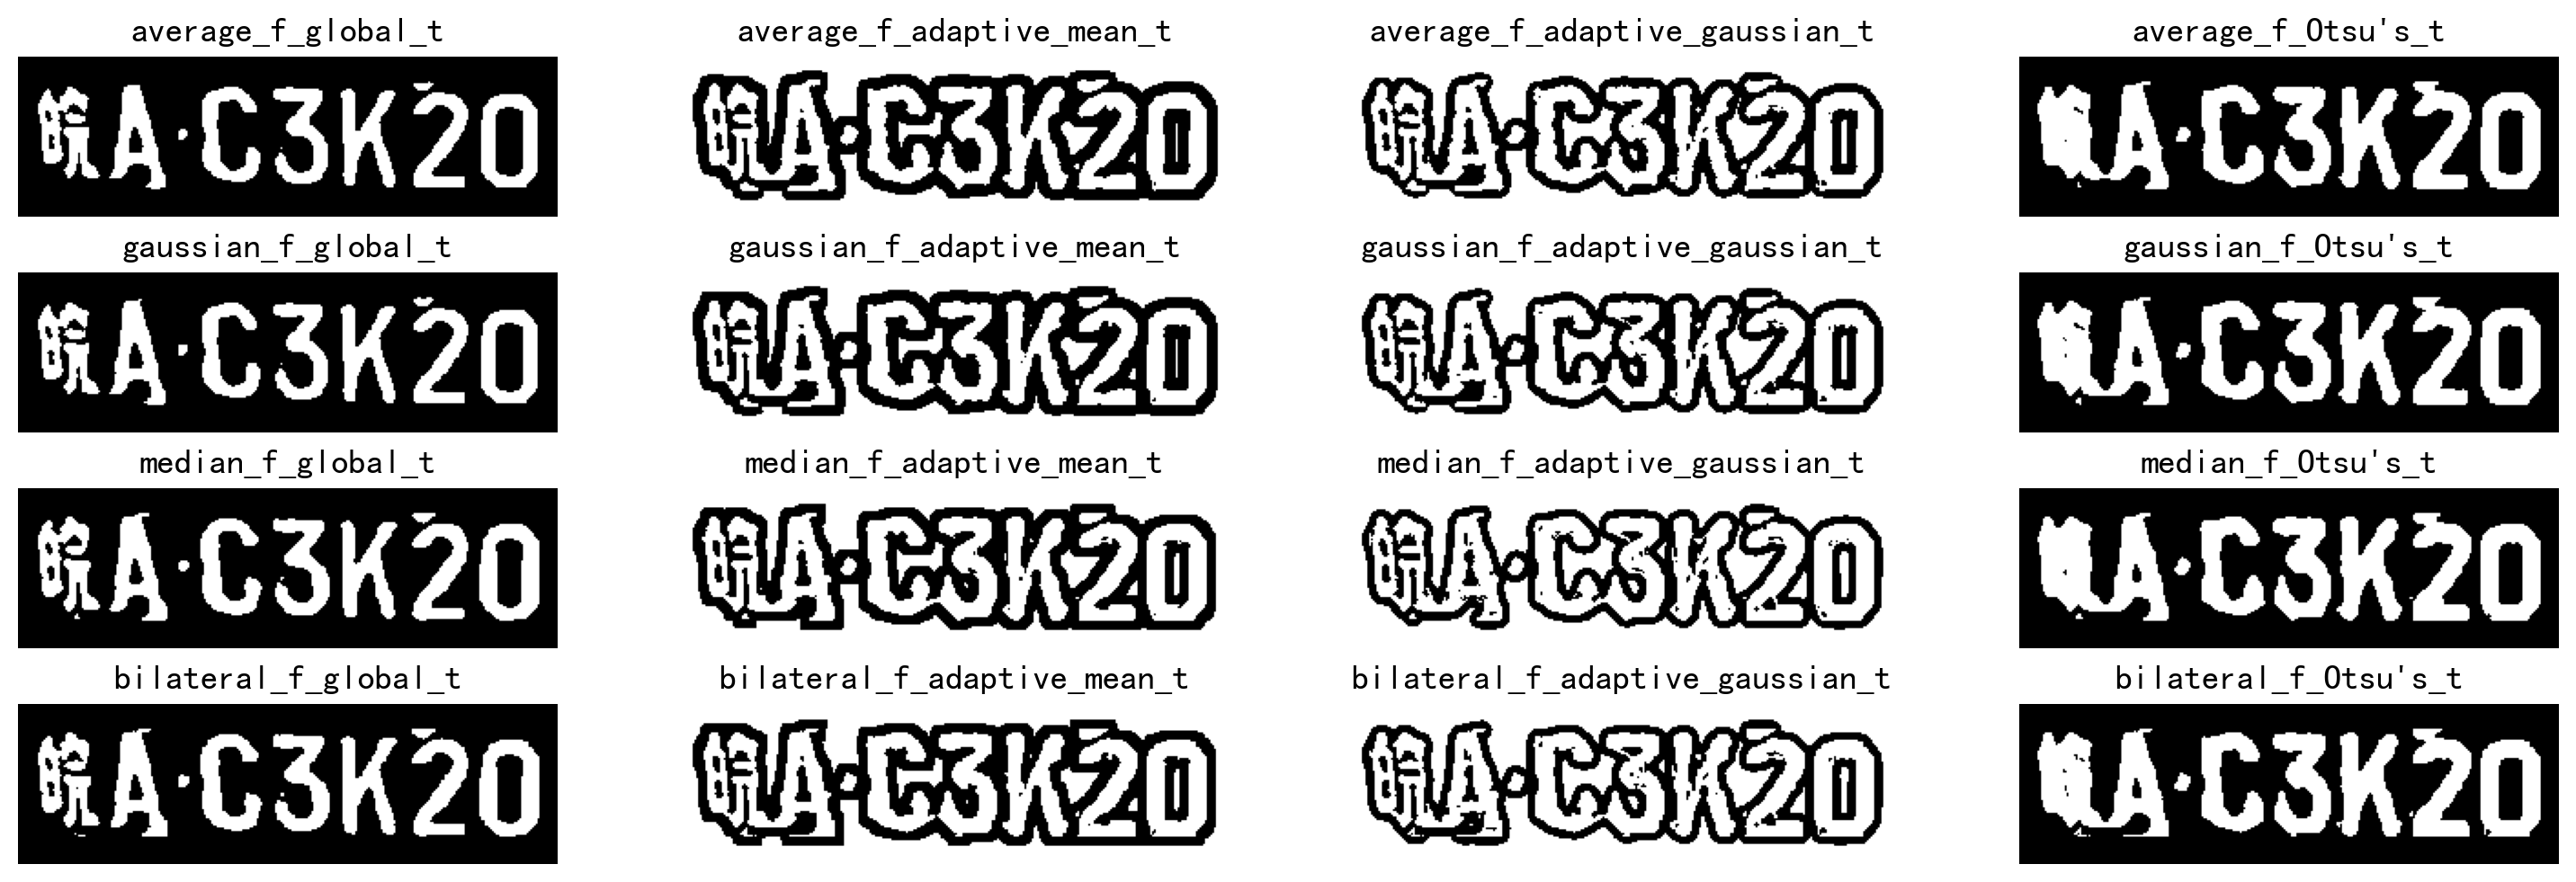

In [37]:
image_bbox_binarys = {}
for title, blur_img in image_bbox_blurs.items():
    threshold = 155 # min(blur_img.mean() + 90, 155)
    image_bbox_binarys[f'{title}_global_t'] = cv2.threshold(
        blur_img, threshold, 255, cv2.THRESH_BINARY)[1]
    image_bbox_binarys[f'{title}_adaptive_mean_t'] =  cv2.adaptiveThreshold(
        blur_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    image_bbox_binarys[f'{title}_adaptive_gaussian_t'] = cv2.adaptiveThreshold(
        blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    image_bbox_binarys[f'{title}_Otsu\'s_t'] = cv2.threshold(
        blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

visualize_data_subplots(len(image_bbox_blurs),
                        int(len(image_bbox_binarys) / len(image_bbox_blurs)),
                        list(image_bbox_binarys.values()),
                        list(image_bbox_binarys.keys()),
                        gray=True)

#### Image Edge Detection

- Sobel(索贝尔算子)
- Scharr(沙尔算子)
- Laplacian(拉普拉斯算子)
- canny


convertScaleAbs:

$$
\texttt{dst} (I) = | \texttt{src} (I)* \texttt{alpha} +  \texttt{beta} |
$$

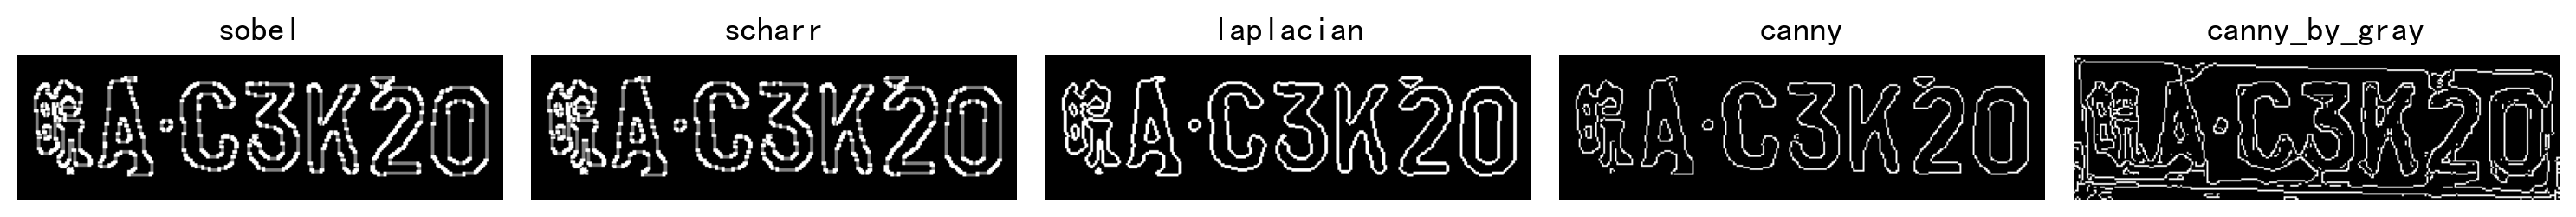

In [38]:
modes = ['median_f_global_t', 'gaussian_f_global_t', 'median_f_Otsu\'s_t']
image_bbox = image_bbox_binarys[modes[0]]

sobel_x = cv2.convertScaleAbs(cv2.Sobel(image_bbox, cv2.CV_64F, 1, 0, ksize=3))
sobel_y = cv2.convertScaleAbs(cv2.Sobel(image_bbox, cv2.CV_64F, 0, 1, ksize=3))
scharr_x = cv2.convertScaleAbs(cv2.Scharr(image_bbox, cv2.CV_64F, 1, 0))
scharr_y = cv2.convertScaleAbs(cv2.Scharr(image_bbox, cv2.CV_64F, 0, 1))

image_bbox_edges = {
    'sobel': cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0),    # 索贝尔算子
    'scharr': cv2.addWeighted(scharr_x, 0.5, scharr_y, 0.5, 0), # 沙尔算子
    'laplacian': cv2.convertScaleAbs(cv2.Laplacian(image_bbox, cv2.CV_64F)),
    'canny': cv2.convertScaleAbs(cv2.Canny(image_bbox, 100, 200)),
    'canny_by_gray': cv2.convertScaleAbs(cv2.Canny(image_bbox_gray, 100, 200))
}

visualize_data_subplots(1, 5,
                        list(image_bbox_edges.values()),
                        list(image_bbox_edges.keys()),
                        gray=True)

#### Morphological Transformations

- Erosion: 
- Dilation:
- Opening: erosion followed by dilation
- Closing: dilation followed by erosion

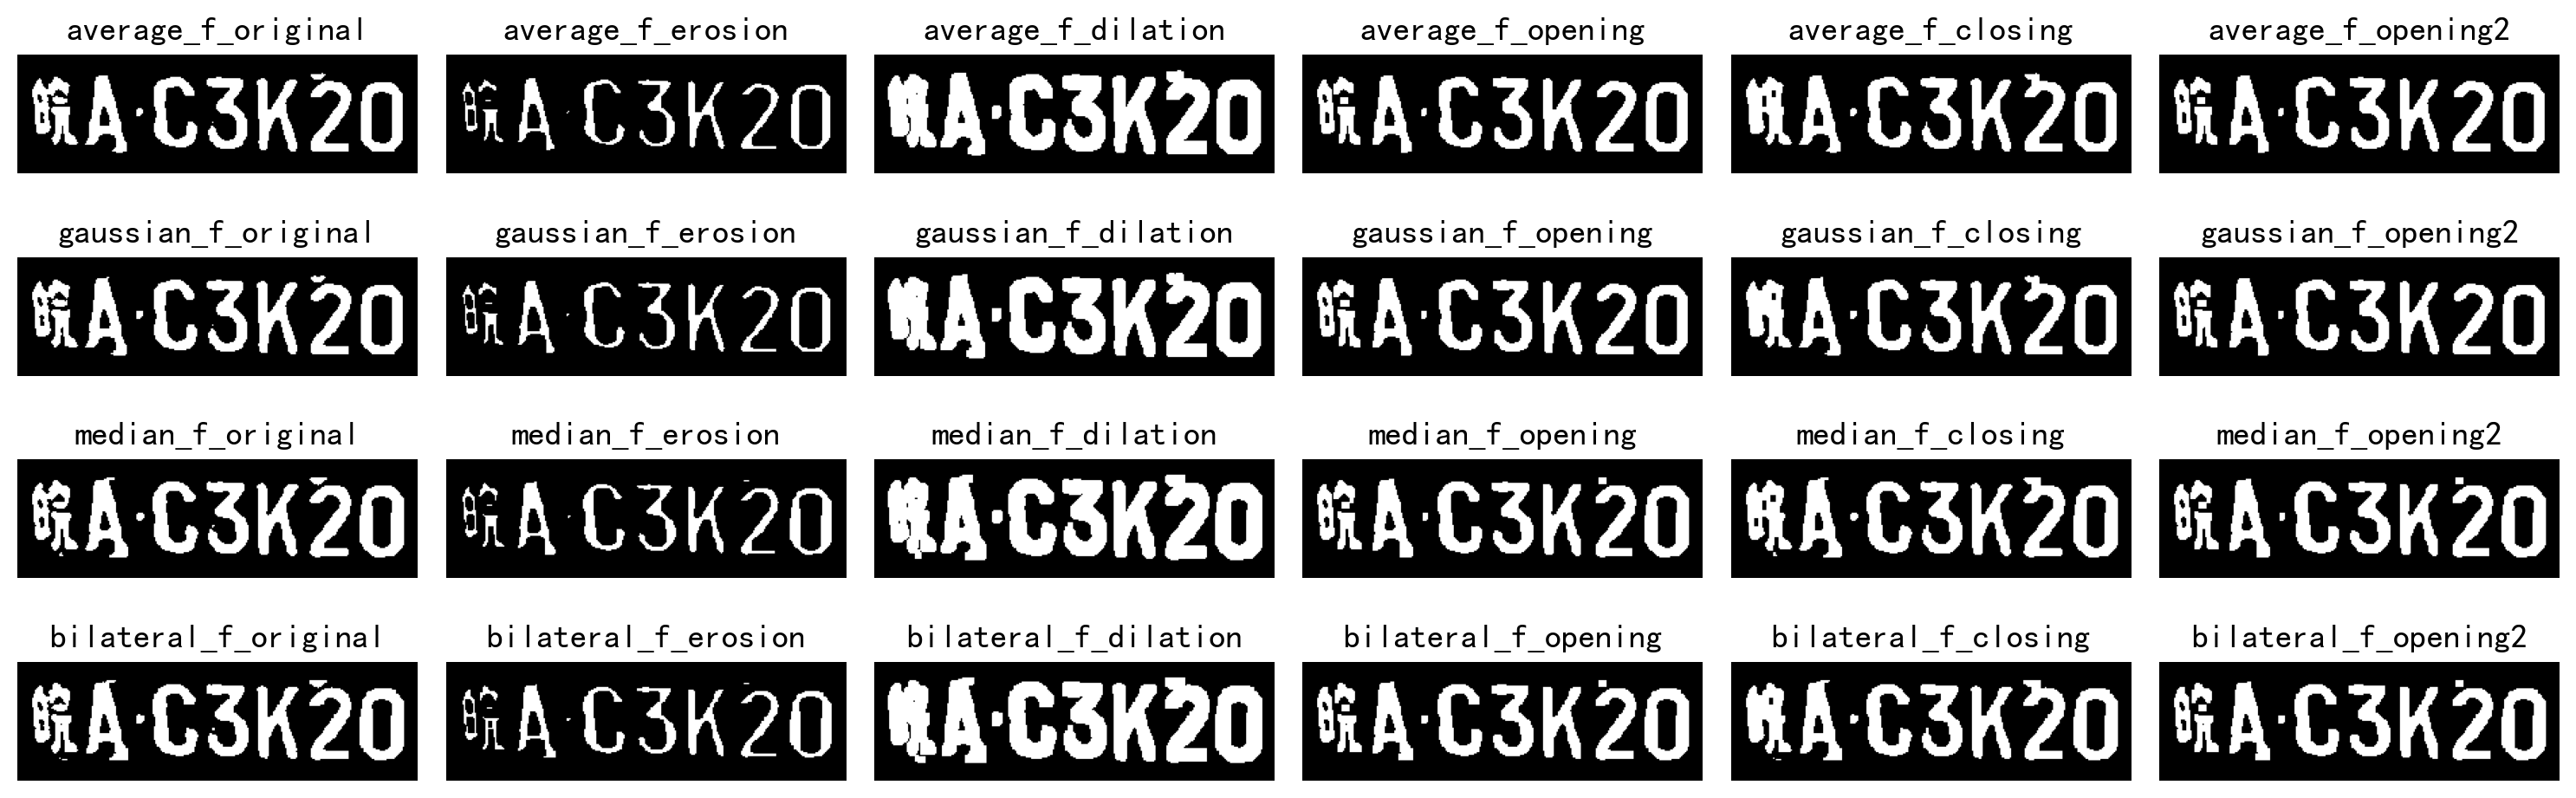

In [39]:
modes = ['global', 'adaptive_mean_t', 'adaptive_gaussian_t', 'Otsu\'s']
bin_mode = modes[0]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 5))
image_bbox_morphs = {}
for title in image_bbox_blurs.keys():
    bin_img = image_bbox_binarys[f'{title}_{bin_mode}_t']
    erode_img = cv2.erode(bin_img, kernel, iterations = 1)
    dilate_img = cv2.dilate(bin_img, kernel, iterations = 1)
    image_bbox_morphs[f'{title}_original'] = bin_img
    image_bbox_morphs[f'{title}_erosion'] = erode_img
    image_bbox_morphs[f'{title}_dilation'] = dilate_img
    image_bbox_morphs[f'{title}_opening'] = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
    image_bbox_morphs[f'{title}_closing'] = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=1)
    image_bbox_morphs[f'{title}_opening2'] = cv2.dilate(erode_img, kernel, iterations=1) # same MORPH_OPEN
    
visualize_data_subplots(len(image_bbox_blurs),
                        int(len(image_bbox_morphs) / len(image_bbox_blurs)),
                        list(image_bbox_morphs.values()),
                        list(image_bbox_morphs.keys()),
                        gray=True)

#### Contours Hierarchy

Detect 7 letters...


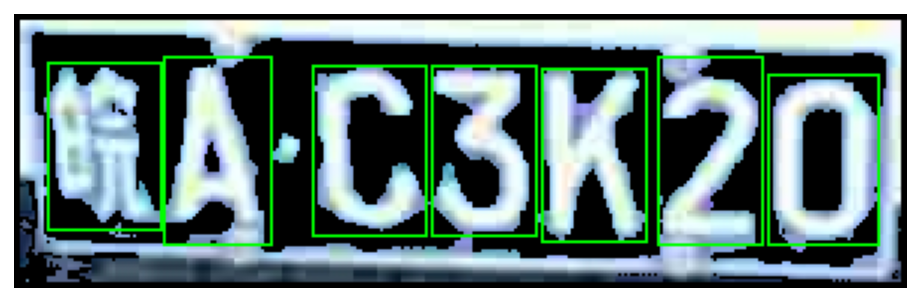

In [40]:
# LP: [provice][alphabet][number]... left to right order
def sort_contours(cnts, reverse = False):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][0], reverse=reverse))
    return cnts

border = 2

image_bbox_morp = image_bbox_morphs['median_f_closing']
image_bbox_morp = cv2.copyMakeBorder(image_bbox_morp, border, border, border, border, cv2.BORDER_CONSTANT, value=0) 

image_bbox_segs = image_bbox_morphs['median_f_original']
image_bbox_segs = cv2.copyMakeBorder(image_bbox_segs, border, border, border, border, cv2.BORDER_CONSTANT, value=0) 

test_plate_image = image_bbox_cropped.copy()
test_plate_image = cv2.copyMakeBorder(test_plate_image, border, border, border, border, cv2.BORDER_CONSTANT, value=0) 

conts = cv2.findContours(image_bbox_morp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

crop_characters = []

digit_w, digit_h = 32, 32

height, width = test_plate_image.shape[:2]

for c in sort_contours(conts):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1 <= ratio <= 3.5:
        if h/height >= 0.3:
            cv2.rectangle(test_plate_image, (x-border, y-border), (x+w+border, y+h+border), (0, 255,0), 1)
            image = image_bbox_segs[y-border:y+h+border, x-border:x+w+border]
            crop_characters.append(cv2.resize(image, dsize=(digit_w, digit_h)))
            
print("Detect {} letters...".format(len(crop_characters)))

imshow(test_plate_image, isbgr=True)

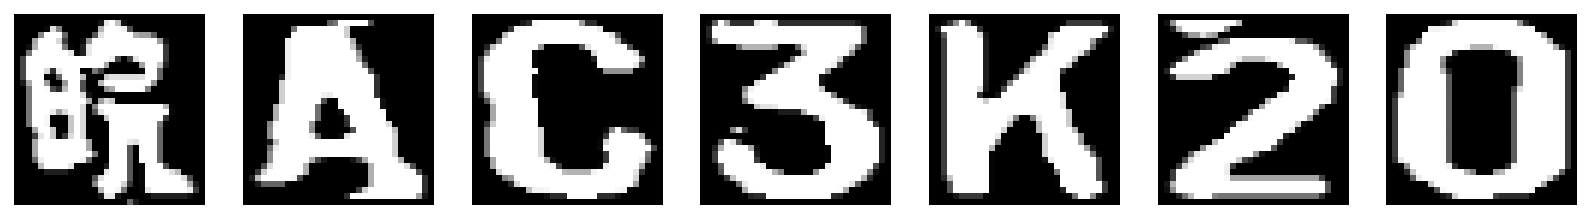

In [41]:
fig = plt.figure(figsize=(14, 4))

grid = gridspec.GridSpec(ncols=len(crop_characters), nrows=1, figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i], cmap="gray")

### Test Summary

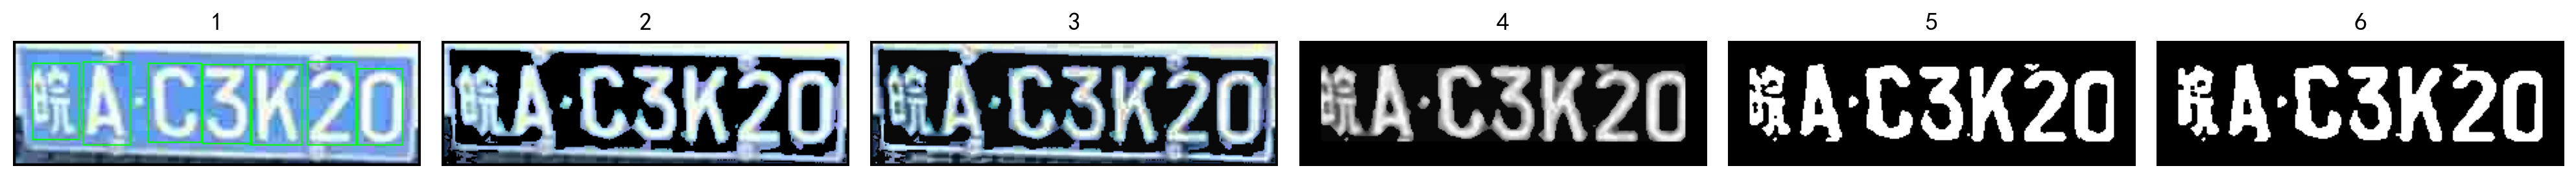

In [57]:
def LPCharSegment(car_plate, debug=False):
    if isinstance(car_plate, str):
        img_bgr = cv2.imread(car_plate)
    elif isinstance(car_plate, np.ndarray):
        img_bgr = car_plate.copy()
    else:
        raise NotImplemented
        
    e = 2
    img_bgr = cv2.copyMakeBorder(img_bgr, e, e, e, e, cv2.BORDER_CONSTANT, value=0) 
    img_h, img_w = img_bgr.shape[:2]
    
    # 1. mask
    blue_lower = np.array([100, 103, 106], np.uint8)
    blue_upper = np.array([120, 255, 255], np.uint8)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, blue_lower, blue_upper)
    mask_inv = cv2.bitwise_not(mask)
    mask_and = cv2.bitwise_and(img_hsv, img_hsv, mask=mask_inv)
    img_mask = cv2.cvtColor(mask_and, cv2.COLOR_HSV2BGR)
    
    # 2. contrast
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10, 10))
    img_lab = cv2.cvtColor(img_mask, cv2.COLOR_BGR2LAB)
    planes = cv2.split(img_lab)
    planes[0] = clahe.apply(planes[0])
    img_clahe = cv2.cvtColor(cv2.merge(planes), cv2.COLOR_LAB2BGR)

    # 3. gray
    img_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    img_gray_tb_mask = np.zeros((img_h, img_w), dtype=np.uint8)
    img_gray_tb_mask[0:int(0.18*img_h), ::] = 255
    img_gray_tb_mask[int(0.82*img_h):, ::] = 255
    img_gray_tb_mask = cv2.bitwise_and(img_gray, img_gray, mask=img_gray_tb_mask)
    
    img_gray_lr_mask = np.zeros((img_h, img_w), dtype=np.uint8)
    img_gray_lr_mask[:, 0:int(0.05*img_w)] = 255
    img_gray_lr_mask[:, int(0.95*img_w):] = 255
    img_gray_lr_mask = cv2.bitwise_and(img_gray, img_gray, mask=img_gray_lr_mask)
    
    # 4. detect: top, bottom, left, right
    img_canny_tb_mask = cv2.convertScaleAbs(cv2.Canny(img_gray_tb_mask, 127, 255))
    img_canny_lr_mask = cv2.convertScaleAbs(cv2.Canny(img_gray_lr_mask, 127, 255))
    
    conts = cv2.findContours(img_canny_tb_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for i, c in enumerate(conts):
        x, y, w, h = cv2.boundingRect(c)
        if w > 0.3 * img_w:
            if y < 0.15 * img_h:
                img_gray[:y+h, ::] = 0
            else:
                img_gray[y:, ::] = 0
                
    conts = cv2.findContours(img_canny_lr_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for i, c in enumerate(conts):
        x, y, w, h = cv2.boundingRect(c)
        if h > 0.5 * img_h:
            if x < 0.05 * img_w:
                img_gray[::, :x+w] = 0
            else:
                img_gray[::, x:] = 0
    
    # 5. median smooth
    img_blur = cv2.medianBlur(img_gray, 3) 
    
    # 6. binary threshold
    img_bin = cv2.threshold(img_blur, 127, 255, cv2.THRESH_BINARY)[1]
    
    # 7. morphological transform
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_morph = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # 8. contour hierarchy (7 segs: left to right )
    def sort_contours(cnts, reverse = False):
        bboxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, bboxes) = zip(*sorted(zip(cnts, bboxes),
                                            key=lambda b: b[1][0], reverse=reverse))
        return cnts

    crop_characters = []
    conts = cv2.findContours(img_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(conts) < 7:
        if debug:
            return [], (img_bgr, img_mask, img_clahe, img_blur, img_bin, img_morph)
        return []

    for c in sort_contours(conts):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1 <= ratio <= 3.5:
            if h/img_bgr.shape[0] >= 0.3:
                if debug:
                    cv2.rectangle(img_bgr, (x-border, y-border), (x+w+border, y+h+border), (0, 255,0), 1)
                    crop_characters.append(cv2.resize(img_bin[y-e:y+h+e, x-e:x+w+e], dsize=(32, 32)))
                    continue
                crop_characters.append(cv2.resize(img_bin[y-e:y+h+e, x-e:x+w+e], dsize=(32, 32)))
    if debug:
        return crop_characters, (img_bgr, img_mask, img_clahe, img_blur, img_bin, img_morph)
    return crop_characters[:7]

imgs7, mid_imgs = LPCharSegment(lp_test_imgs[2], debug=True)
if 0 < len(imgs7):
    visualize_data_subplots(1, len(imgs7), imgs7, gray=True)
visualize_data_subplots(1, len(mid_imgs), mid_imgs, isbgr=True, gray=True)

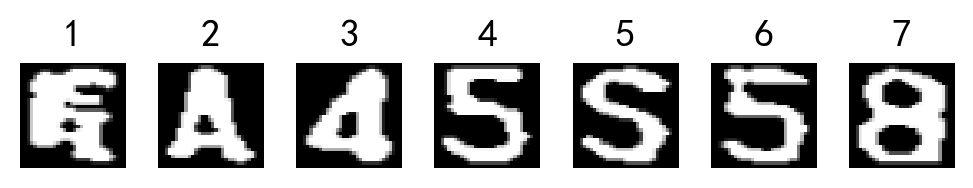

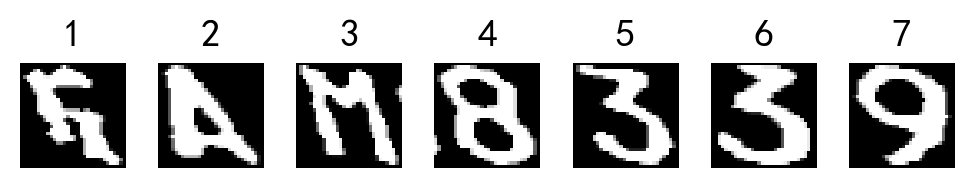

In [43]:
## Test
visualize_data_subplots(1, len(lp_test_imgs), lp_test_imgs, isbgr=True)
for i, img_bgr in enumerate(lp_test_imgs):
    imgs7 = LPCharSegment(img_bgr)
    if 0 < len(imgs7) == 7:
        visualize_data_subplots(1, len(imgs7), imgs7, gray=True)

-------------------

## Plate Classification Using MobileNets 

### Dataset

[BaiduYun Drive(code: nf8t)](https://pan.baidu.com/s/1R-dY79sNomty8lQu6gJ88w)

In [44]:
pl_data_root = '/data/datasets/cv/CarPlateIdentity'
char_image_path = os.path.join(pl_data_root, 'cnn_char_train')

!ls $char_image_path 

0  6  C  J  Q  W	zh_gan	 zh_ji	  zh_meng   zh_su     zh_yu1
1  7  D  K  R  X	zh_gan1  zh_jin   zh_min    zh_sx     zh_yue
2  8  E  L  S  Y	zh_gui	 zh_jing  zh_ning   zh_wan    zh_yun
3  9  F  M  T  Z	zh_gui1  zh_jl	  zh_qing   zh_xiang  zh_zang
4  A  G  N  U  zh_cuan	zh_hei	 zh_liao  zh_qiong  zh_xin    zh_zhe
5  B  H  P  V  zh_e	zh_hu	 zh_lu	  zh_shan   zh_yu


In [45]:
zh_provinces = {
    'zh_cuan': '川', 'zh_e': '鄂', 'zh_gan': '赣', 'zh_gan1': '甘',
    'zh_gui': '贵', 'zh_gui1': '桂', 'zh_hei': '黑', 'zh_hu': '沪',
    'zh_ji': '冀', 'zh_jin': '津', 'zh_jing': '京', 'zh_jl': '吉',
    'zh_liao': '辽', 'zh_lu': '鲁', 'zh_meng': '蒙', 'zh_min': '闽',
    'zh_ning': '宁', 'zh_qing': '青', 'zh_qiong': '琼', 'zh_shan': '陕',
    'zh_su': '苏',  'zh_sx': '晋', 'zh_wan': '皖', 'zh_xiang': '湘',
    'zh_xin': '新', 'zh_yu': '豫', 'zh_yu1': '渝', 'zh_yue': '粤',
    'zh_yun': '云', 'zh_zang': '藏', 'zh_zhe': '浙'
}

label_names = sorted(os.listdir(char_image_path))
print(' '.join(label_names))
label_mapids = {name: i for i, name in enumerate(label_names)}

def get_label_name(labelid):
    name = label_names[labelid]
    if name[:2] == 'zh':
        return zh_provinces[name]
    return name

0 1 2 3 4 5 6 7 8 9 A B C D E F G H J K L M N P Q R S T U V W X Y Z zh_cuan zh_e zh_gan zh_gan1 zh_gui zh_gui1 zh_hei zh_hu zh_ji zh_jin zh_jing zh_jl zh_liao zh_lu zh_meng zh_min zh_ning zh_qing zh_qiong zh_shan zh_su zh_sx zh_wan zh_xiang zh_xin zh_yu zh_yu1 zh_yue zh_yun zh_zang zh_zhe


In [46]:
all_char_images = {
    'number': {},
    'province': {},
    'alphabet': {}
}

for d in label_names:
    data = []
    for it in os.scandir(os.path.join(char_image_path, d)):
        if not it.is_file():
            continue
        data.append(it.path)
        
    if d[:2] == 'zh':
        all_char_images['province'][d] = data
    elif ord(d) <= 57: # ord('9')
        all_char_images['number'][d] = data
    else:
        all_char_images['alphabet'][d] = data
        
all_class_count = 0
all_image_count = 0

for tykey, tyval in all_char_images.items():
    print('-' * 20, tykey, '-' * 20)
    cls_count = 0
    img_count = 0
    for key, val in all_char_images[tykey].items():
        if cls_count % 5 == 0:
            print('')
        labelid = label_mapids[key]
        if key[:2] == 'zh':
            key = zh_provinces[key]
        print('{:>4}({:>2}): {:<4d}'.format(key, labelid, len(val)), end='')
        cls_count += 1
        img_count += len(val)
    print('\n\n%4s count: %-3d image count: %-3d\n' % (tykey, cls_count, img_count))
    
    all_class_count += cls_count
    all_image_count += img_count

print('-'*50, '\nClass Total: %-3d\tImage Total: %-6d' % (all_class_count, all_image_count))

-------------------- number --------------------

   0( 0): 715    1( 1): 517    2( 2): 601    3( 3): 587    4( 4): 401 
   5( 5): 973    6( 6): 758    7( 7): 824    8( 8): 1152   9( 9): 1166

number count: 10  image count: 7694

-------------------- province --------------------

   川(34): 123    鄂(35): 63     赣(36): 80     甘(37): 46     贵(38): 53  
   桂(39): 32     黑(40): 101    沪(41): 203    冀(42): 95     津(43): 240 
   京(44): 147    吉(45): 52     辽(46): 79     鲁(47): 104    蒙(48): 53  
   闽(49): 67     宁(50): 32     青(51): 36     琼(52): 30     陕(53): 73  
   苏(54): 219    晋(55): 92     皖(56): 172    湘(57): 90     新(58): 19  
   豫(59): 169    渝(60): 42     粤(61): 160    云(62): 35     藏(63): 6   
   浙(64): 260 

province count: 31  image count: 2973

-------------------- alphabet --------------------

   A(10): 1013   B(11): 422    C(12): 300    D(13): 213    E(14): 299 
   F(15): 238    G(16): 266    H(17): 213    J(18): 164    K(19): 266 
   L(20): 265    M(21): 243    N(22): 203  

### Data Preprocess

#### Visualize Data Distribution


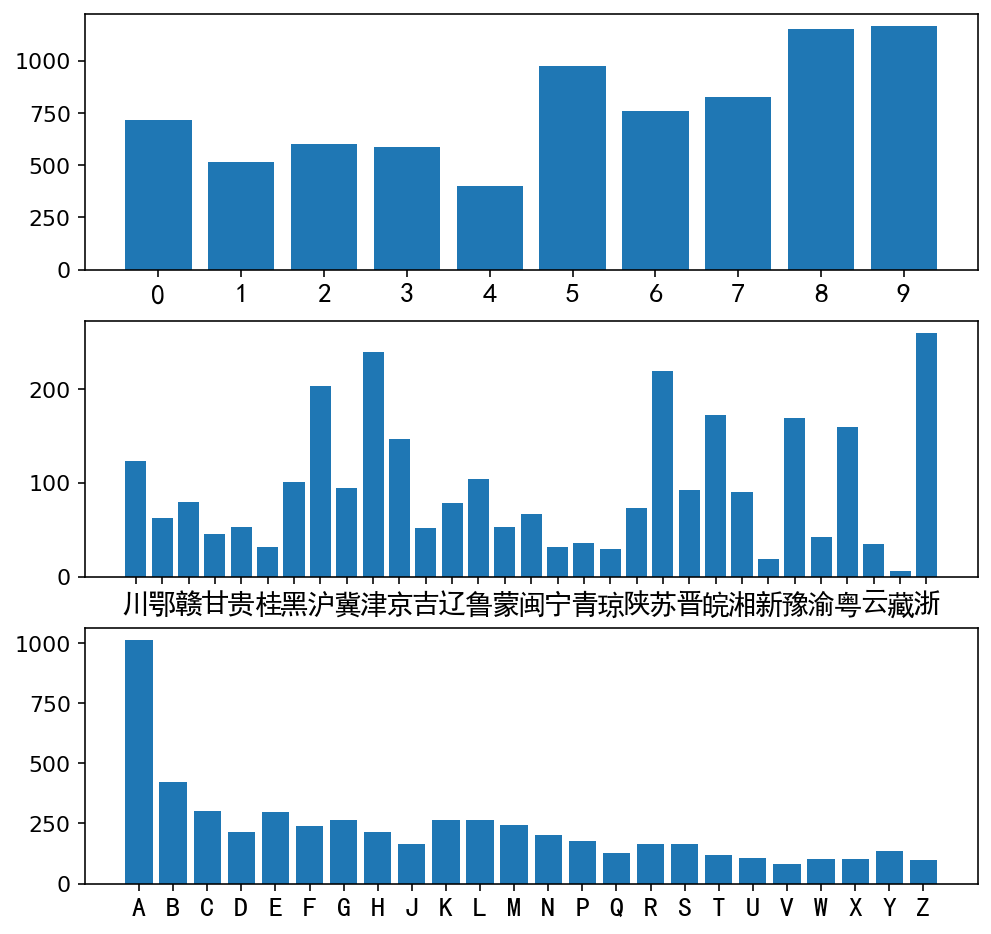

In [47]:
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))

for i, (tykey, tyval) in enumerate(all_char_images.items()):
    index = range(len(tyval))
    value = [len(x) for x in list(tyval.values())]
    labels = [zh_provinces[x] if tykey == 'province' else x for x in list(tyval.keys())]
    axes[i].bar(index, value)
    axes[i].set_xticks(index)
    axes[i].set_xticklabels(labels, fontproperties=zh_font)

#### Train Data and Valid Data

In [48]:
split_rate = 0.2 # Train 0.8, Valid 0.2
train_data = {}
valid_data = {}
for tykey, tyval in all_char_images.items():
    for label, paths in all_char_images[tykey].items():
        random.shuffle(paths)
        split = int(split_rate * len(paths))
        valid_data[label] = paths[0:split]
        train_data[label] = paths[split:]

#### Visualize Subplots Sample

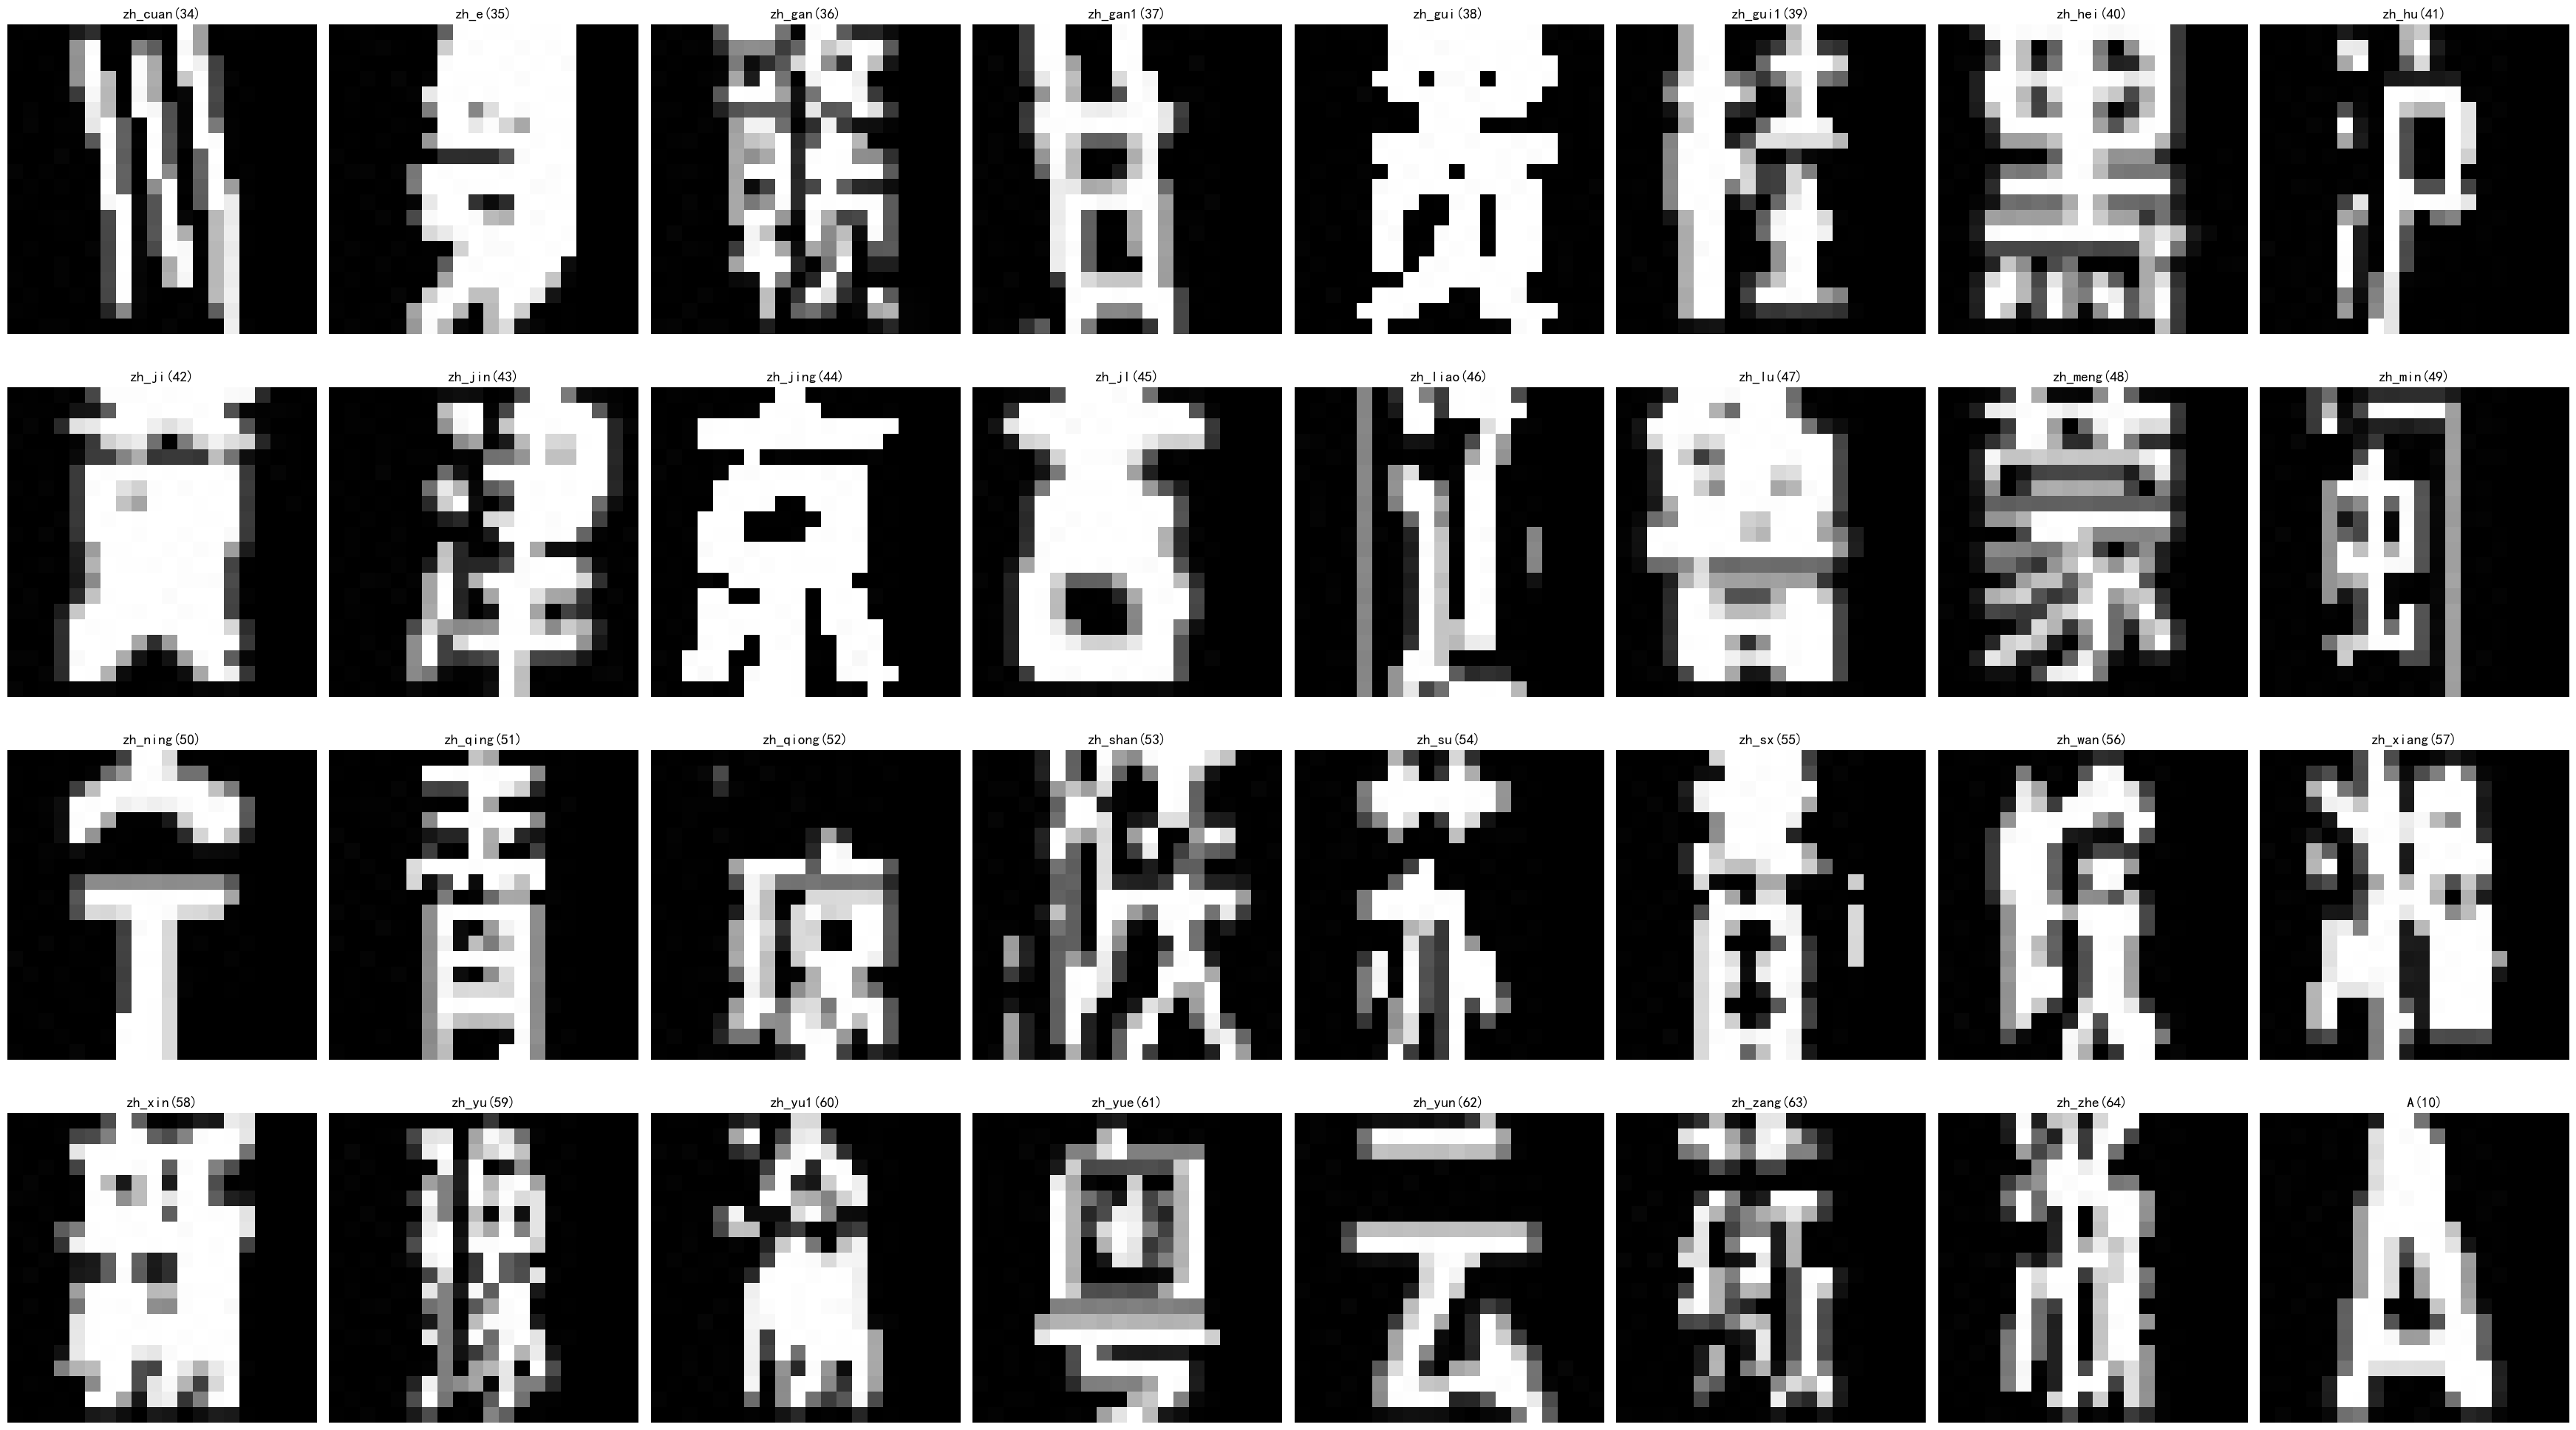

In [49]:
def make_sample_data(data):
    samples = []
    titles = []
    for label, path in data.items():
        samples.append(random.choice(path))
        titles.append(u'%4s(%d)' % (label, label_mapids[label]))
    return samples, titles

samples_data, titles = make_sample_data(valid_data)
visualize_data_subplots(4, 8, samples_data[10:42], titles=titles[10:42], resize=20, dpi=50)

### Train MobilenetV2

In [50]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import mobilenet_v2
from torch.utils.data import (Dataset, DataLoader)
from torchvision.transforms import (
    Resize,
    Compose,
    ToTensor,
    Normalize,
    RandomRotation)

input_size = 20
num_classes = len(label_mapids)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data Loader

In [51]:
class CharDataset(Dataset):
    def __init__(self, data, input_size):
        self.input_size = input_size
        self.mean, self.std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        self.images = []
        self.labels = []
        for key, val in data.items():
            label = label_mapids[key]
            for image in val:
                self.images.append(image)
                self.labels.append(label)
        
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        # augment
        tensor_image = Compose([
            RandomRotation(10),
            Resize(self.input_size),
            ToTensor(),
            Normalize(mean=self.mean, std=self.std)])(img)
        return tensor_image, self.labels[index]

    def __len__(self):
        return len(self.images)
    
train_dataloader = DataLoader(
    CharDataset(train_data, input_size),
    batch_size=1024,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

valid_dataloader = DataLoader(
    CharDataset(valid_data, input_size),
    batch_size=128,
    shuffle=False,
    drop_last=False,
    pin_memory=False
)

#### Model Loader

In [52]:
net = mobilenet_v2(pretrained=True)
net.classifier[1] = torch.nn.Linear(net.classifier[1].in_features, num_classes)
net.to(device);

#### Hyper Parameters

In [53]:
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
# optimizer = optim.Adam(net.parameters(), lr=0.01)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.8, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=6)

#### Start Train

In [54]:
def train_epoch(epoch, model, device, data_loader, criterion, optimizer):
    model.train()
    correct = 0.0
    allloss = []
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = torch.max(output, 1)[1]
        correct += (pred == target).sum().item()
        allloss.append(loss)
    acc = 100.0 * correct / len(data_loader.dataset)
    return acc, torch.stack(allloss).mean()

def valid_epoch(epoch, model, device, data_loader, criterion):
    model.eval()
    correct = 0.0
    allloss = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            pred = torch.max(output, 1)[1]
            correct += (pred == target).sum().item()
            allloss.append(loss)
    acc = 100.0 * correct / len(data_loader.dataset)
    return acc, torch.stack(allloss).mean()

def train(epoch_num, net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, retrain=False):
    ckpt_model = os.path.join(pl_data_root, 'model.pth')
    # ckpt_optimizer = os.path.join(pl_data_root,'optimizer.pth')
    if not retrain:
        if os.path.exists(ckpt_model):
            net.load_state_dict(torch.load(ckpt_model))
        # if os.path.exists(ckpt_optimizer):
        #     optimizer.load_state_dict(torch.load(ckpt_optimizer))
        
    device = next(net.parameters()).device
    for epoch in range(1, epoch_num+1):
        acc1, loss1 = train_epoch(epoch, net, device, train_dataloader, criterion, optimizer)
        acc2, loss2 = valid_epoch(epoch, net, device, valid_dataloader, criterion)
        # scheduler.step(acc2)
        scheduler.step(acc1)
        print('[%2d/%3d]: Acc[%.2f%% vs %.2f%%] Loss[%.6f vs %.6f] LR%s' % (
            epoch, epoch_num,
            acc1, acc2, loss1, loss2,
            [group['lr'] for group in optimizer.param_groups]))
        
    torch.save(net.state_dict(), os.path.join(pl_data_root, 'model.pth'))
    # torch.save(optimizer.state_dict(), os.path.join(pl_data_root,'optimizer.pth'))

In [55]:
train(1, net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler)

[ 1/  1]: Acc[94.74% vs 99.78%] Loss[0.008055 vs 0.008514] LR[0.01]


#### Predict

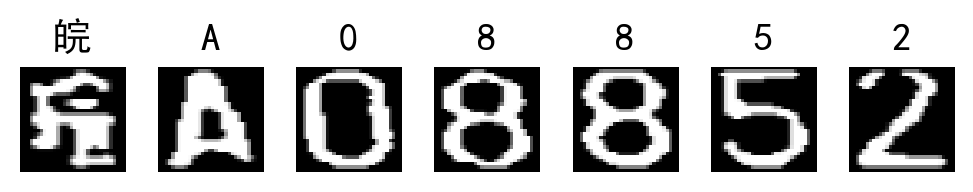

In [56]:
def predict(net, image_or_paths, input_size=20):
    if not isinstance(image_or_paths, (list, tuple)):
        image_or_paths = [image_or_paths]
        
    ckpt_model = os.path.join(pl_data_root, 'model.pth')
    if os.path.exists(ckpt_model):
        net.load_state_dict(torch.load(ckpt_model))
        
    device = next(net.parameters()).device
    
    imgs = []
    for image_or_path in image_or_paths:
        if isinstance(image_or_path, str):
            img = Image.open(image_or_path)
        elif isinstance(image_or_path, np.ndarray):
            if len(image_or_path.shape) == 2:
                img = cv2.cvtColor(image_or_path, cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.cvtColor(image_or_path, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)  
        else:
            raise NotImplemented
        transform = Compose([
                Resize(input_size),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
        imgs.append(transform(img))
        
    if len(imgs) == 1:
        tensor_imgs = imgs[0].unsqueeze(0)
    else:
        tensor_imgs = torch.stack(imgs, dim=0)
        
    net.eval()
    with torch.no_grad():
        output = net(tensor_imgs.to(device))
        return output.argmax(dim=1).cpu().tolist()

result = predict(net, imgs7)
result = [get_label_name(x) for x in result]
visualize_data_subplots(1, len(result), imgs7, titles=result, gray=True)

## References

- https://iopscience.iop.org/article/10.1088/1742-6596/1792/1/012073/pdf

- https://blog.csdn.net/GK_2014/article/details/84779166

- https://blog.csdn.net/IT_charge/article/details/107427133

- https://techvidvan.com/tutorials/python-project-license-number-plate-recognition/

- [Difference between Top-Hat and Black-Hat](https://www.geeksforgeeks.org/top-hat-and-black-hat-transform-using-python-opencv/)
> The top-hat filter is used to enhance bright objects of interest in a dark background. The black-hat operation is used to do the opposite, enhance dark objects of interest in a bright background.

- [Opening & Closing](https://cvexplained.wordpress.com/2020/05/18/opening-closing/)
> Performing an opening operation allows us to remove small blobs from an image: first an erosion is applied to remove the small blobs, then a dilation is applied to regrow the size of the original object.  
> A closing is used to close holes inside of objects or for connecting components together. Closing – dilation followed by erosion.

- [Edge Detector](https://hubofco.de/machinelearning/2020/04/08/Egde-detection-in-open-cv/)

- [形态学操作—膨胀与腐蚀](https://www.jianshu.com/p/a8ee3674c061)

- https://medium.com/@quangnhatnguyenle/detect-and-recognize-vehicles-license-plate-with-machine-learning-and-python-part-3-recognize-be2eca1a9f12

- [bilateral filter双边滤波器的通俗理解](https://panjinquan.blog.csdn.net/article/details/82660826)

- [Otsu’s method 奥斯/大津二值方法](https://medium.com/@MinghaoNing/otsus-method-db49e2f85093)

- [Sobel导数，Scharr滤波器，Laplacian算子，Canny边缘检测](https://www.itdaan.com/tw/339dc4ec398c9fbb16f50eaecef15d2b)

- https://blog.csdn.net/s294878304/article/details/103134533

- [CLAHE 限制对比度自适应直方图均衡化](https://blog.csdn.net/qq_43743037/article/details/107195117)

- [OpenCV——对比度增强](https://blog.csdn.net/hushaoqiqimingxing/article/details/92080833)

- https://towardsdatascience.com/increase-your-face-recognition-models-accuracy-by-improving-face-contrast-a3e71bb6b9fb